In [1]:
%load_ext autoreload
%autoreload 
    
import time
import sys
sys.path.insert(0, "../")

from leitmotifs.plotting import *
from leitmotifs.lama import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

def find_label(motif_sets, elbow_points, annotations, start):
    labels = []
    for pos in motif_sets[elbow_points[-1]]:
        try:
            # print (pos)
            value = annotations.loc[start+pos:start+pos+window_size]["description"].values[0]
            labels.append(value)
            # print(value)
        except IndexError:
            pass
    # print (labels)
    try :
        return pd.Series(labels).mode().iloc[0]
    except:
        return ""
    return ""

def plot_motiflet(series, motiflet, motif_length, title=None):    
    fig, ax = plt.subplots(figsize=(4,2))

    offset = 0.0
    for dim in range(series.shape[0]):
        dim_data_raw = pd.DataFrame(data=np.array([series[dim, i:i+motif_length] for i in motiflet]))        
        offset -= 2 * (dim_data_raw.values.max() - dim_data_raw.values.min())
        # display(dim_data_raw - offset)        
        ax = sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset) # , ci=100
    
    if title:
        ax.set_title(title)
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.axis('off')
    return fig, ax


def find_dominant_window_sizes(X, offset=0.05):
    """Determine the Window-Size using dominant FFT-frequencies.

    Parameters
    ----------
    X : array-like, shape=[n]
        a single univariate time series of length n
    offset : float
        Exclusion Radius

    Returns
    -------
    trivial_match: bool
        If the candidate change point is a trivial match
    """
    fourier = np.absolute(np.fft.fft(X))
    freqs = np.fft.fftfreq(X.shape[0], 1)

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)

    idx = np.argsort(coefs)[::-1]
    return next(
        (
            int(window_size / 2)
            for window_size in window_sizes[idx]
            if window_size in range(20, int(X.shape[0] * offset))
        ),
        window_sizes[idx[0]],
    )

In [2]:
sampling_factor = 2

series_channel0 = pd.read_csv("../datasets/arrhythmia/subject231_channel0.csv")[::sampling_factor]
series_channel1 = pd.read_csv("../datasets/arrhythmia/subject231_channel1.csv")[::sampling_factor]
series = pd.concat([series_channel0, series_channel1], axis=1).T

cps = np.array([0, 35142, 53625, 120082, 202337, 287941, 375925, 433855, 448425, 458808, 507445, series.shape[1] * sampling_factor]) // sampling_factor
cps_class = np.array([0, 34220,  52200,  119239,  202665,  205078,  287902,  291706,  376266,  395680,  433289,  449030,  458827,  507749, series.shape[1] * sampling_factor]) // sampling_factor

# series
# series.head()

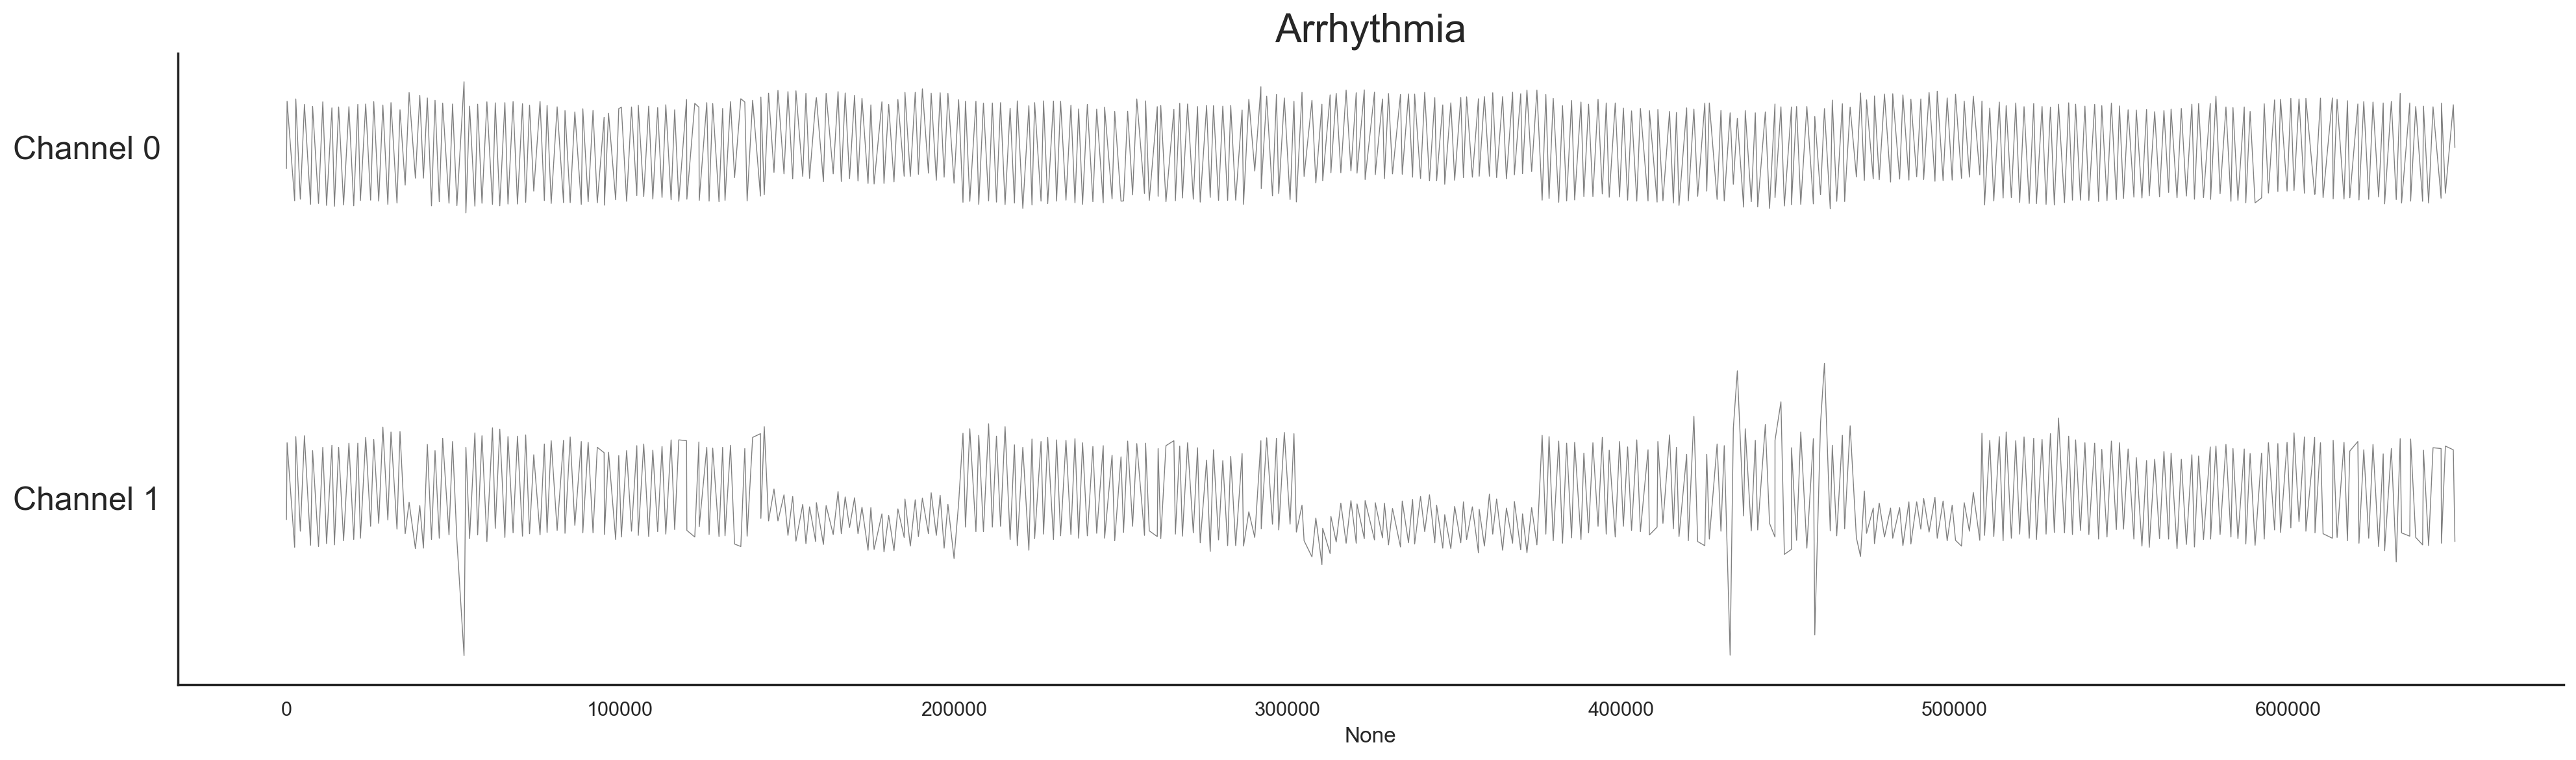

In [3]:
f = 2         
ds_name = "Arrhythmia"

# initialize LAMA
ml = LAMA(
    ds_name,  
    series,
    dimension_labels=series.index,
    n_dims=f,   # number of sub-dimensions
)

_ = ml.plot_dataset()

{0: 0, 17571: 1, 26812: 2, 60041: 3, 101168: 4, 143970: 5, 187962: 6, 216927: 7, 224212: 8, 229404: 9, 253722: 10, 325000: 11}


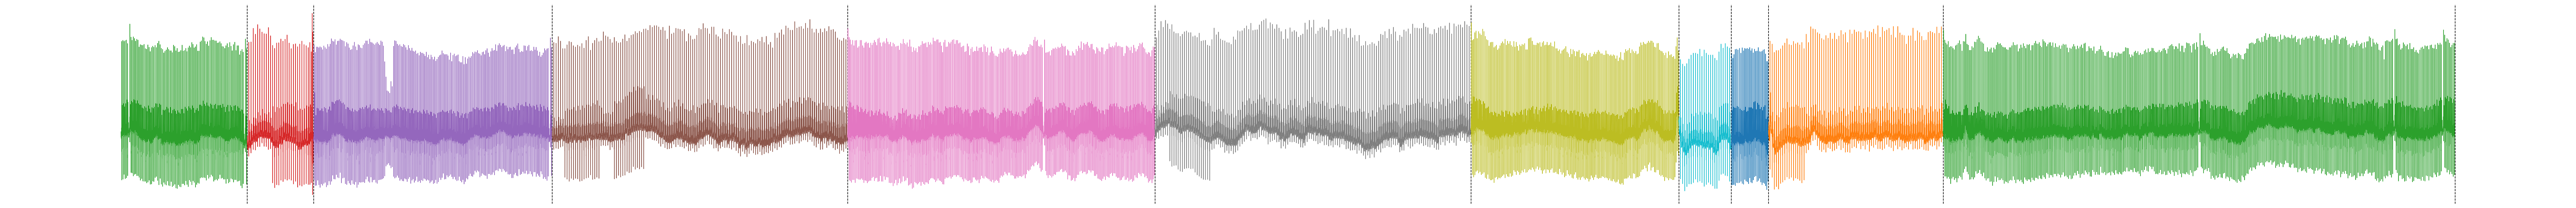

In [4]:
unique = np.unique(cps)
mapping = dict(zip(unique, np.arange(len(unique))))
colors = sns.color_palette("tab10")
print(mapping)

fix, ax = plt.subplots(figsize=(60, 5))

for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
    label = cps[i]  
    
    if label in mapping:
        c = colors[(mapping[label]+2) % len(colors)]
    else:
        c = "black"
        
    sns.lineplot(x=np.arange(a,b), linewidth=1,
                 y=series.iloc[0, a:b], ax = ax, label=label,
                 color=c)
    
    ax.axvline(x=b, color="black", linestyle="--", linewidth=1)
    
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
ax.legend().set_visible(False)
ax.axis('off')
plt.tight_layout()

In [5]:
annotation_dict = {
    " ": ['NOTANN', 'Not an actual annotation'],
    "N": ['NORMAL', 'Normal beat'],
    "L": ['LBBB', 'Left bundle branch block beat'],
    "R": ['RBBB', 'Right bundle branch block beat'],
    "a": ['ABERR', 'Aberrated atrial premature beat'],
    "V": ['PVC', 'Premature ventricular contraction'],
    "F": ['FUSION', 'Fusion of ventricular and normal beat'],
    "J": ['NPC', 'Nodal (junctional) premature beat'],
    "A": ['APC', 'Atrial premature contraction'],
    "S": ['SVPB', 'Premature or ectopic supraventricular beat'],
    "E": ['VESC', 'Ventricular escape beat'],
    "j": ['NESC', 'Nodal (junctional) escape beat'],
    "/": ['PACE', 'Paced beat'],
    "Q": ['UNKNOWN', 'Unclassifiable beat'],
    "~": ['NOISE', 'Signal quality change'],
    "|": ['ARFCT',  'Isolated QRS-like artifact'],
    "s": ['STCH',  'ST change'],
    "T": ['TCH',  'T-wave change'],
    "*": ['SYSTOLE',  'Systole'],
    "D": ['DIASTOLE',  'Diastole'],
    '"': ['NOTE',  'Comment annotation'],
    "=": ['MEASURE',  'Measurement annotation'],
    "p": ['PWAVE',  'P-wave peak'],
    "B": ['BBB',  'Left or right bundle branch block'],
    "^": ['PACESP',  'Non-conducted pacer spike'],
    "t": ['TWAVE',  'T-wave peak'],
    "+": ['RHYTHM',  'Rhythm change'],
    "u": ['UWAVE',  'U-wave peak'],
    "?": ['LEARN',  'Learning'],
    "!": ['FLWAV',  'Ventricular flutter wave'],
    "[": ['VFON',  'Start of ventricular flutter/fibrillation'],
    "]": ['VFOFF',  'End of ventricular flutter/fibrillation'],
    "e": ['AESC',  'Atrial escape beat'],
    "n": ['SVESC',  'Supraventricular escape beat'],
    "@": ['LINK',  'Link to external data (aux_note contains URL)'],
    "x": ['NAPC',  'Non-conducted P-wave (blocked APB)'],
    "f": ['PFUS',  'Fusion of paced and normal beat'],
    "(": ['WFON',  'Waveform onset'],
    ")": ['WFOFF',  'Waveform end'],
    "r": ['RONT',  'R-on-T premature ventricular contraction']    
}

annotations = pd.read_csv("../datasets/arrhythmia/subject231_annotation.csv", delimiter=",", index_col=0)
short_descr = annotations.applymap(lambda l : annotation_dict[l][0]).rename(columns={"annotation":"short_description"})
descr = annotations.applymap(lambda l : annotation_dict[l][1]).rename(columns={"annotation":"description"})
annotations = annotations.assign(**short_descr)
annotations = annotations.assign(**descr)
annotations.index = annotations.reset_index()["timestamp"].transform(lambda l: l//sampling_factor)
annotations

annotation short_description                     description
timestamp                                                             
28                 +            RHYTHM                   Rhythm change
90                 R              RBBB  Right bundle branch block beat
263                R              RBBB  Right bundle branch block beat
423                R              RBBB  Right bundle branch block beat
583                R              RBBB  Right bundle branch block beat
...              ...               ...                             ...
324228             R              RBBB  Right bundle branch block beat
324405             R              RBBB  Right bundle branch block beat
324571             R              RBBB  Right bundle branch block beat
324750             R              RBBB  Right bundle branch block beat
324931             R              RBBB  Right bundle branch block beat

[2011 rows x 3 columns]

# Run ClaSS to determine Segments

In [6]:
#from src.clazz.segmentation import ClaSS
#from benchmark.utils import run_stream

#stream = ClaSS(n_timepoints=10_000, n_prerun=min(10_000, series.shape[0]))
#profile, runtimes, found_cps, found_cps_dx = run_stream(stream, series, aggregate_profile=np.max)
#scores = stream.scores

# Run LAMA on each segment

Start 0 End 17110
Data (2, 17110)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 168
Elbow Points [11 13 16]  found in 8.4 s


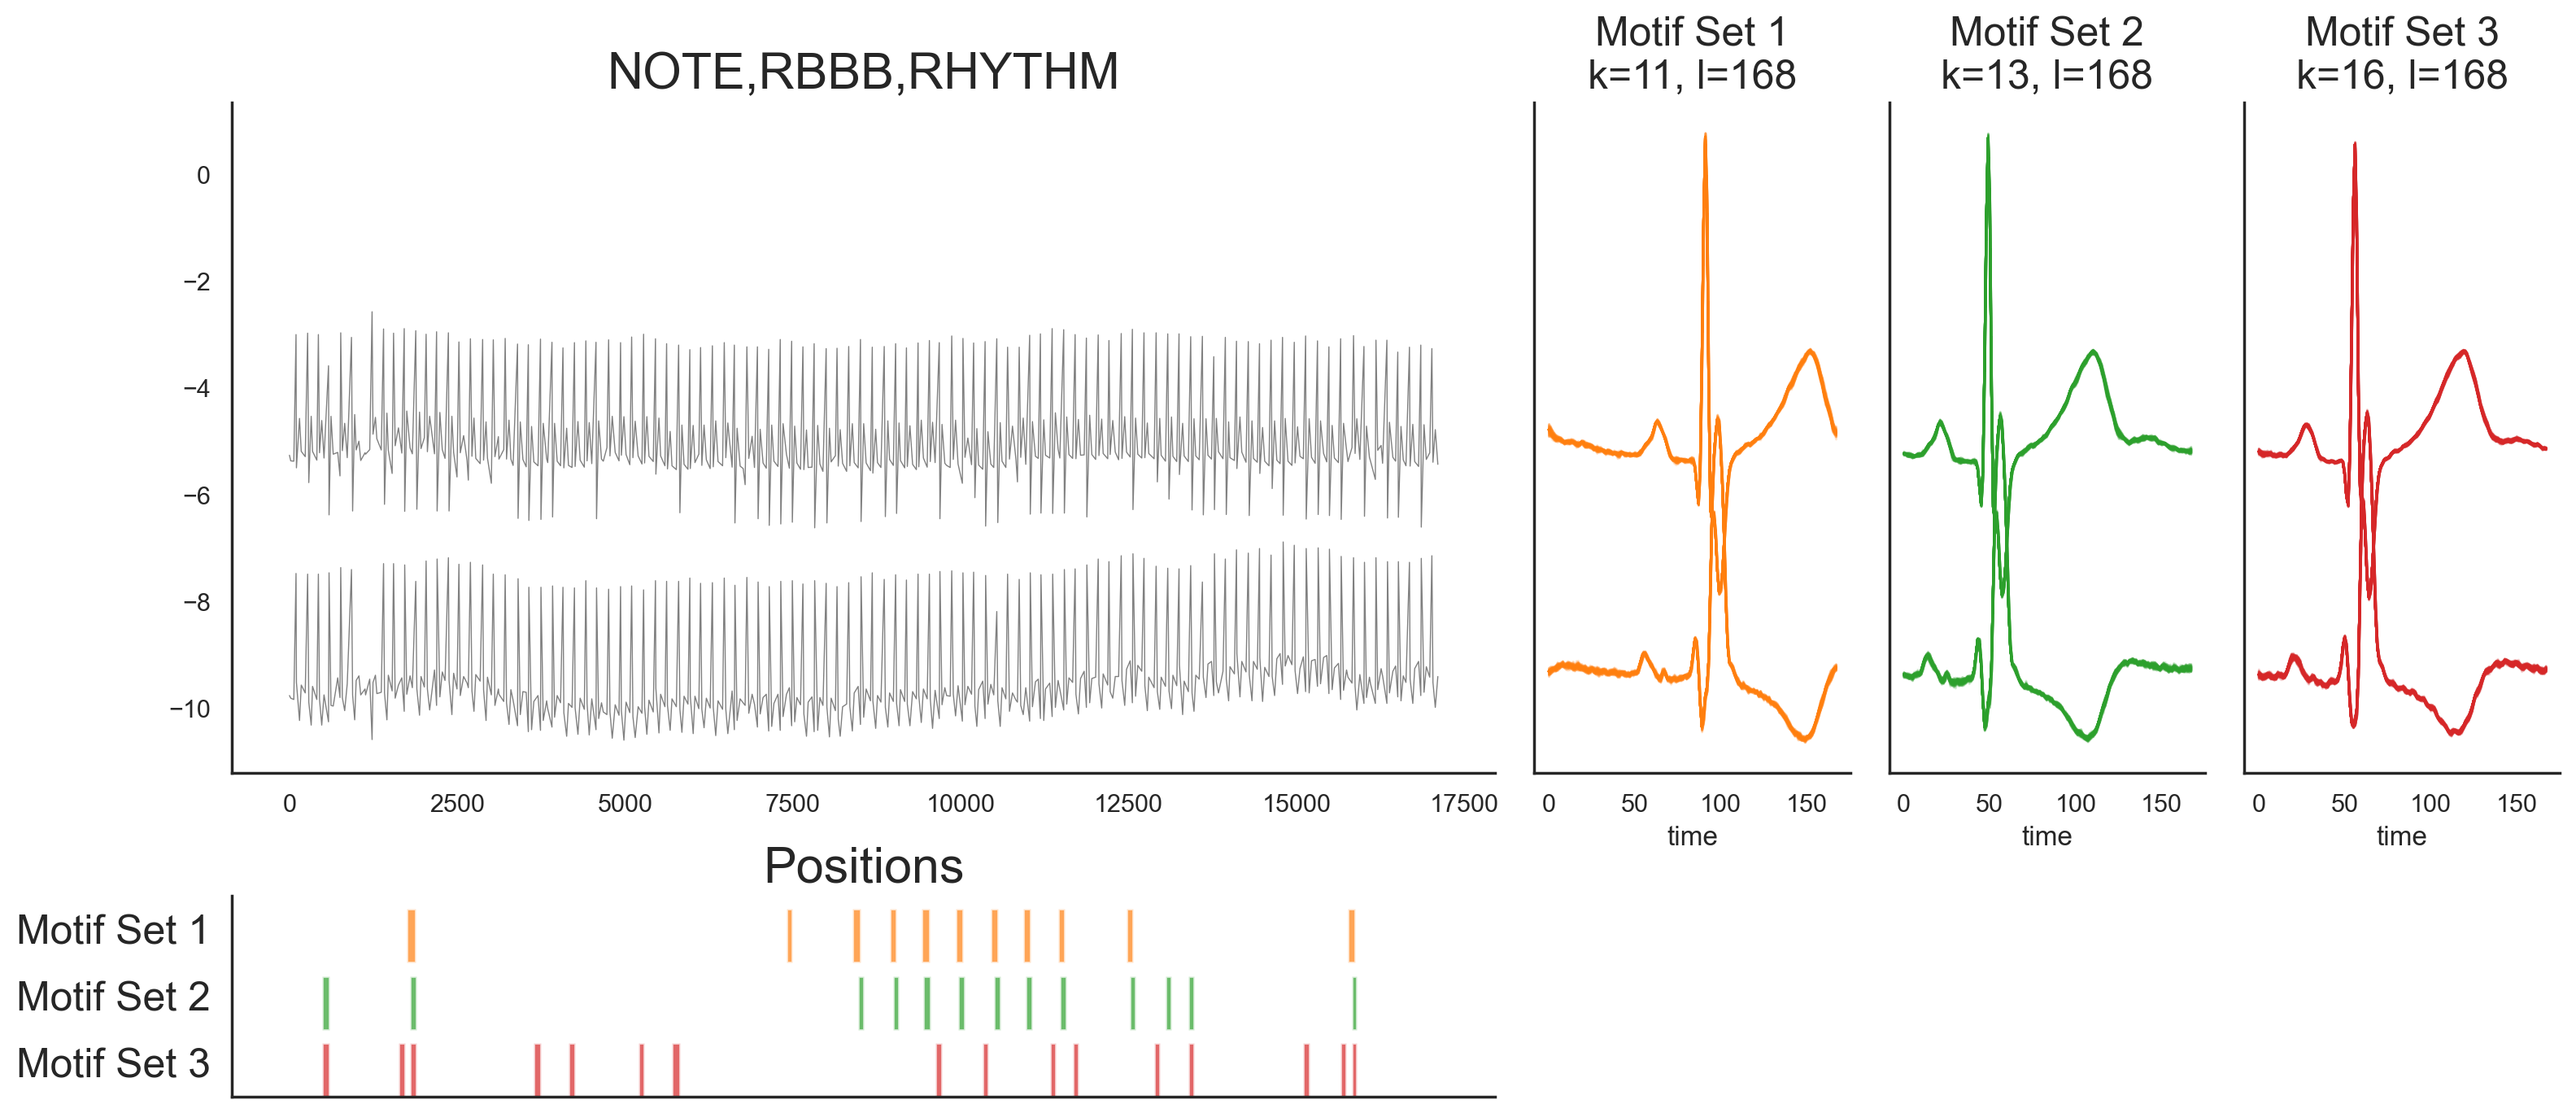

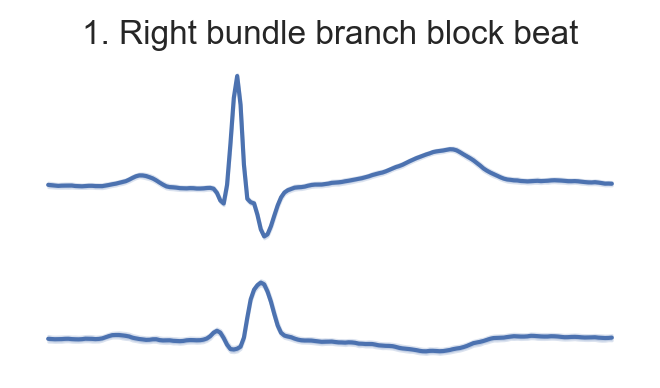

Start 17110 End 26100
Data (2, 8990)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 290
Elbow Points [18]  found in 0.8 s


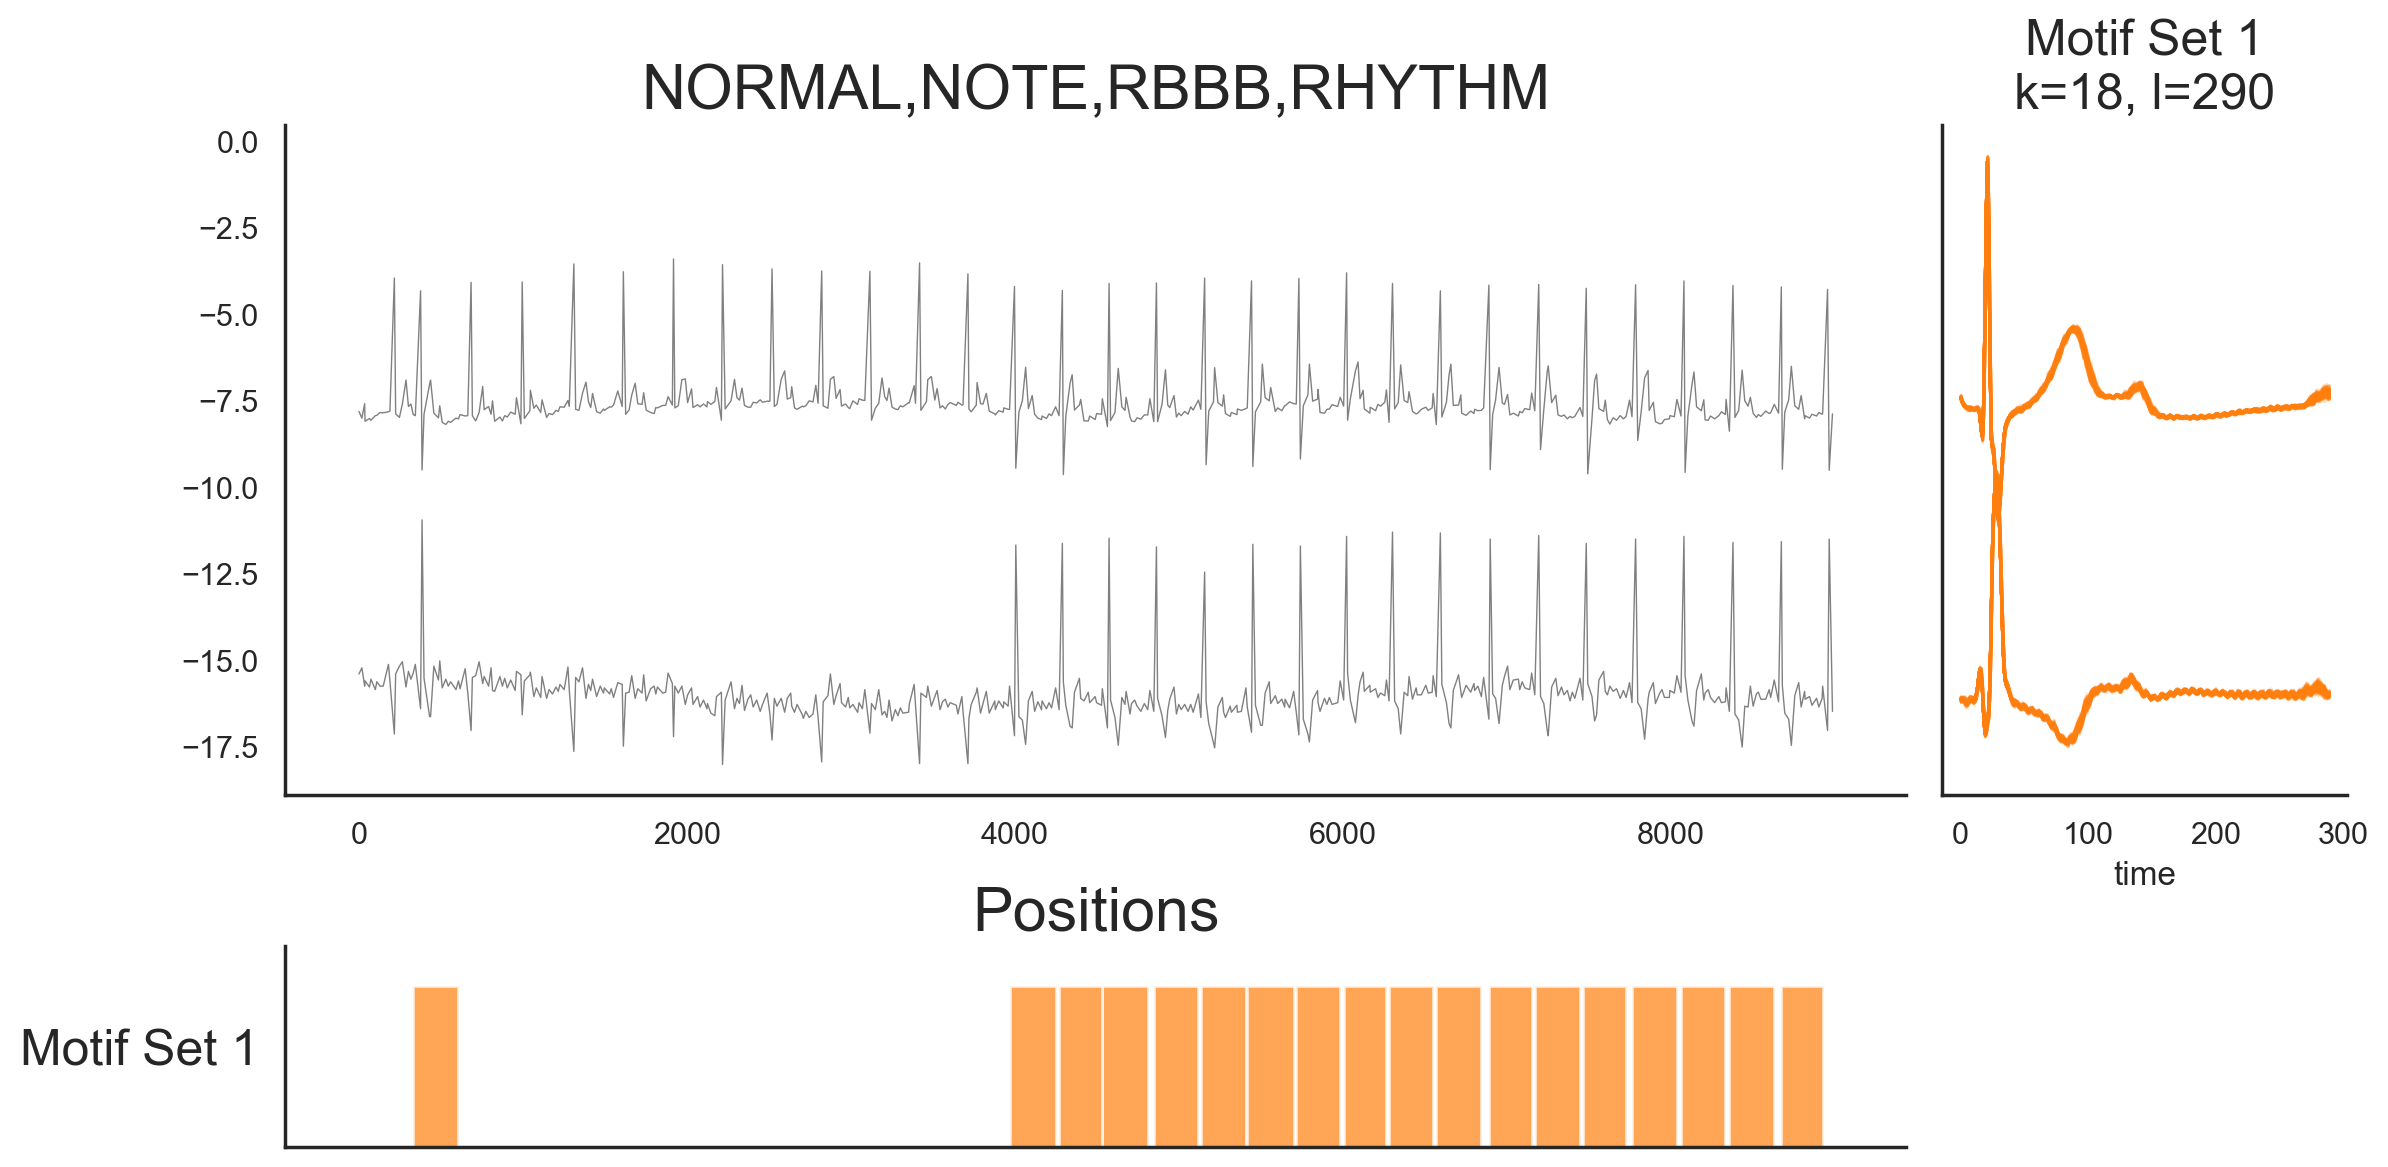

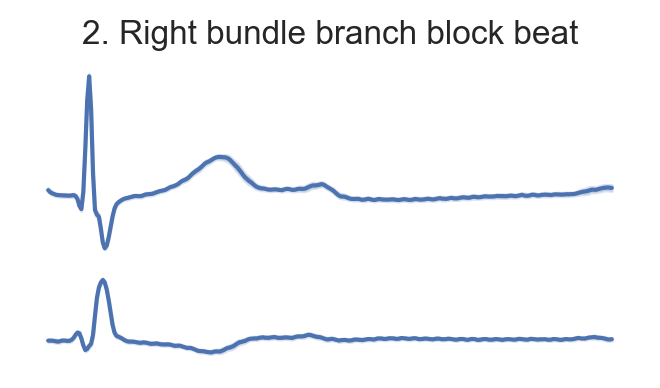

Start 26100 End 59619
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 176
Elbow Points [2]  found in 6.4 s


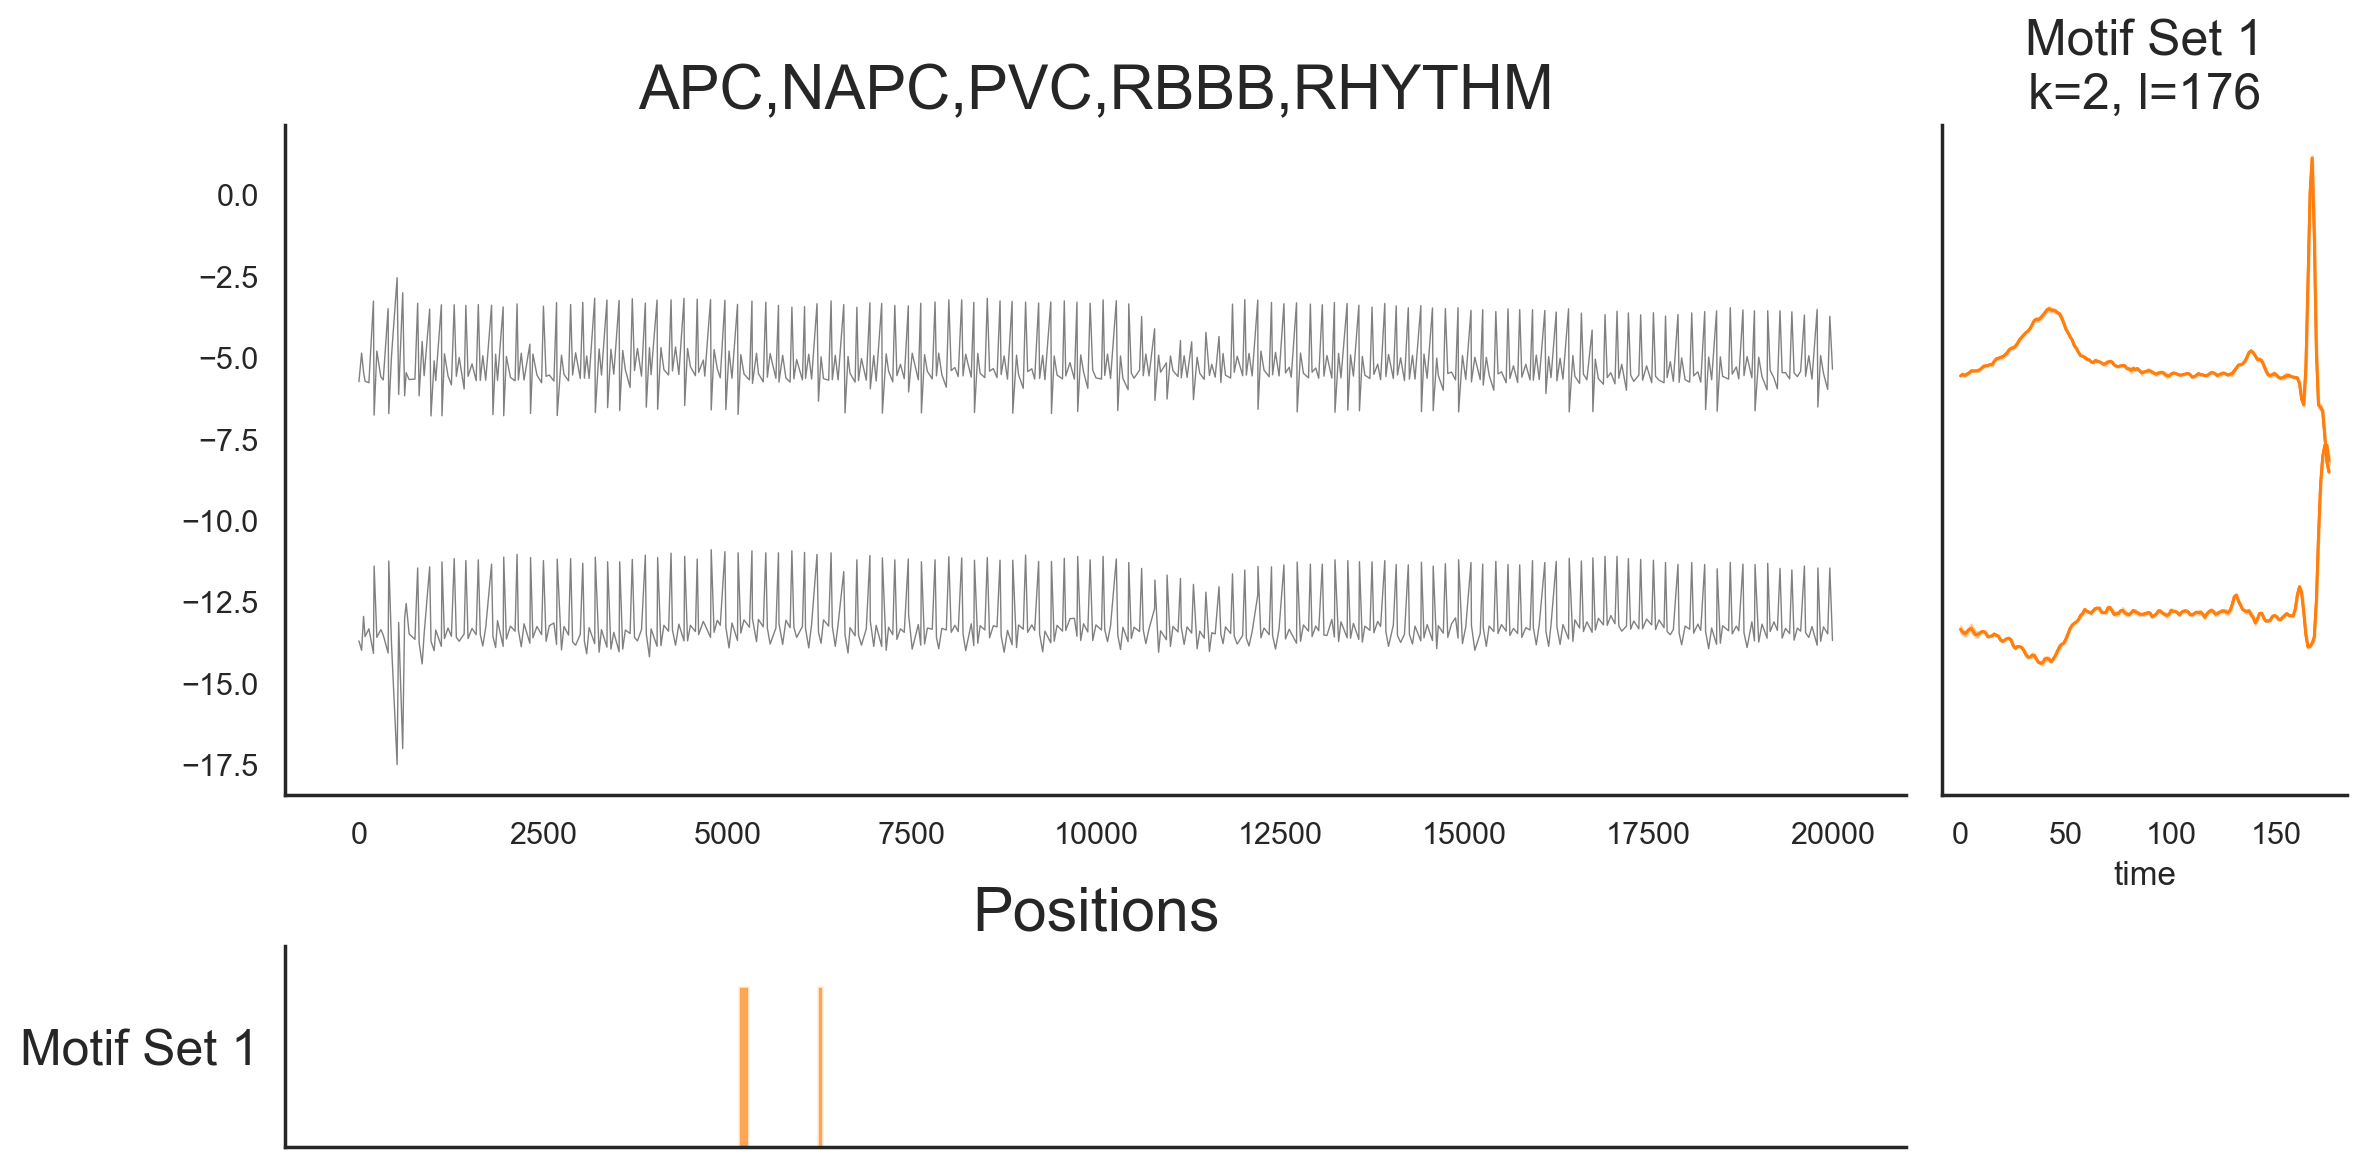

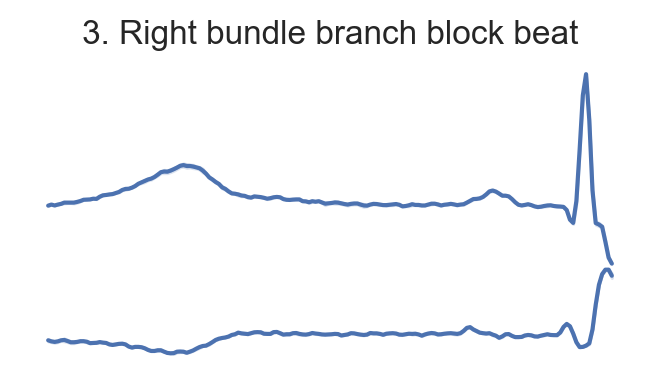

Start 59619 End 101332
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:01<?, ?it/s]

Window-size: 298
Elbow Points [ 8 15]  found in 16.2 s


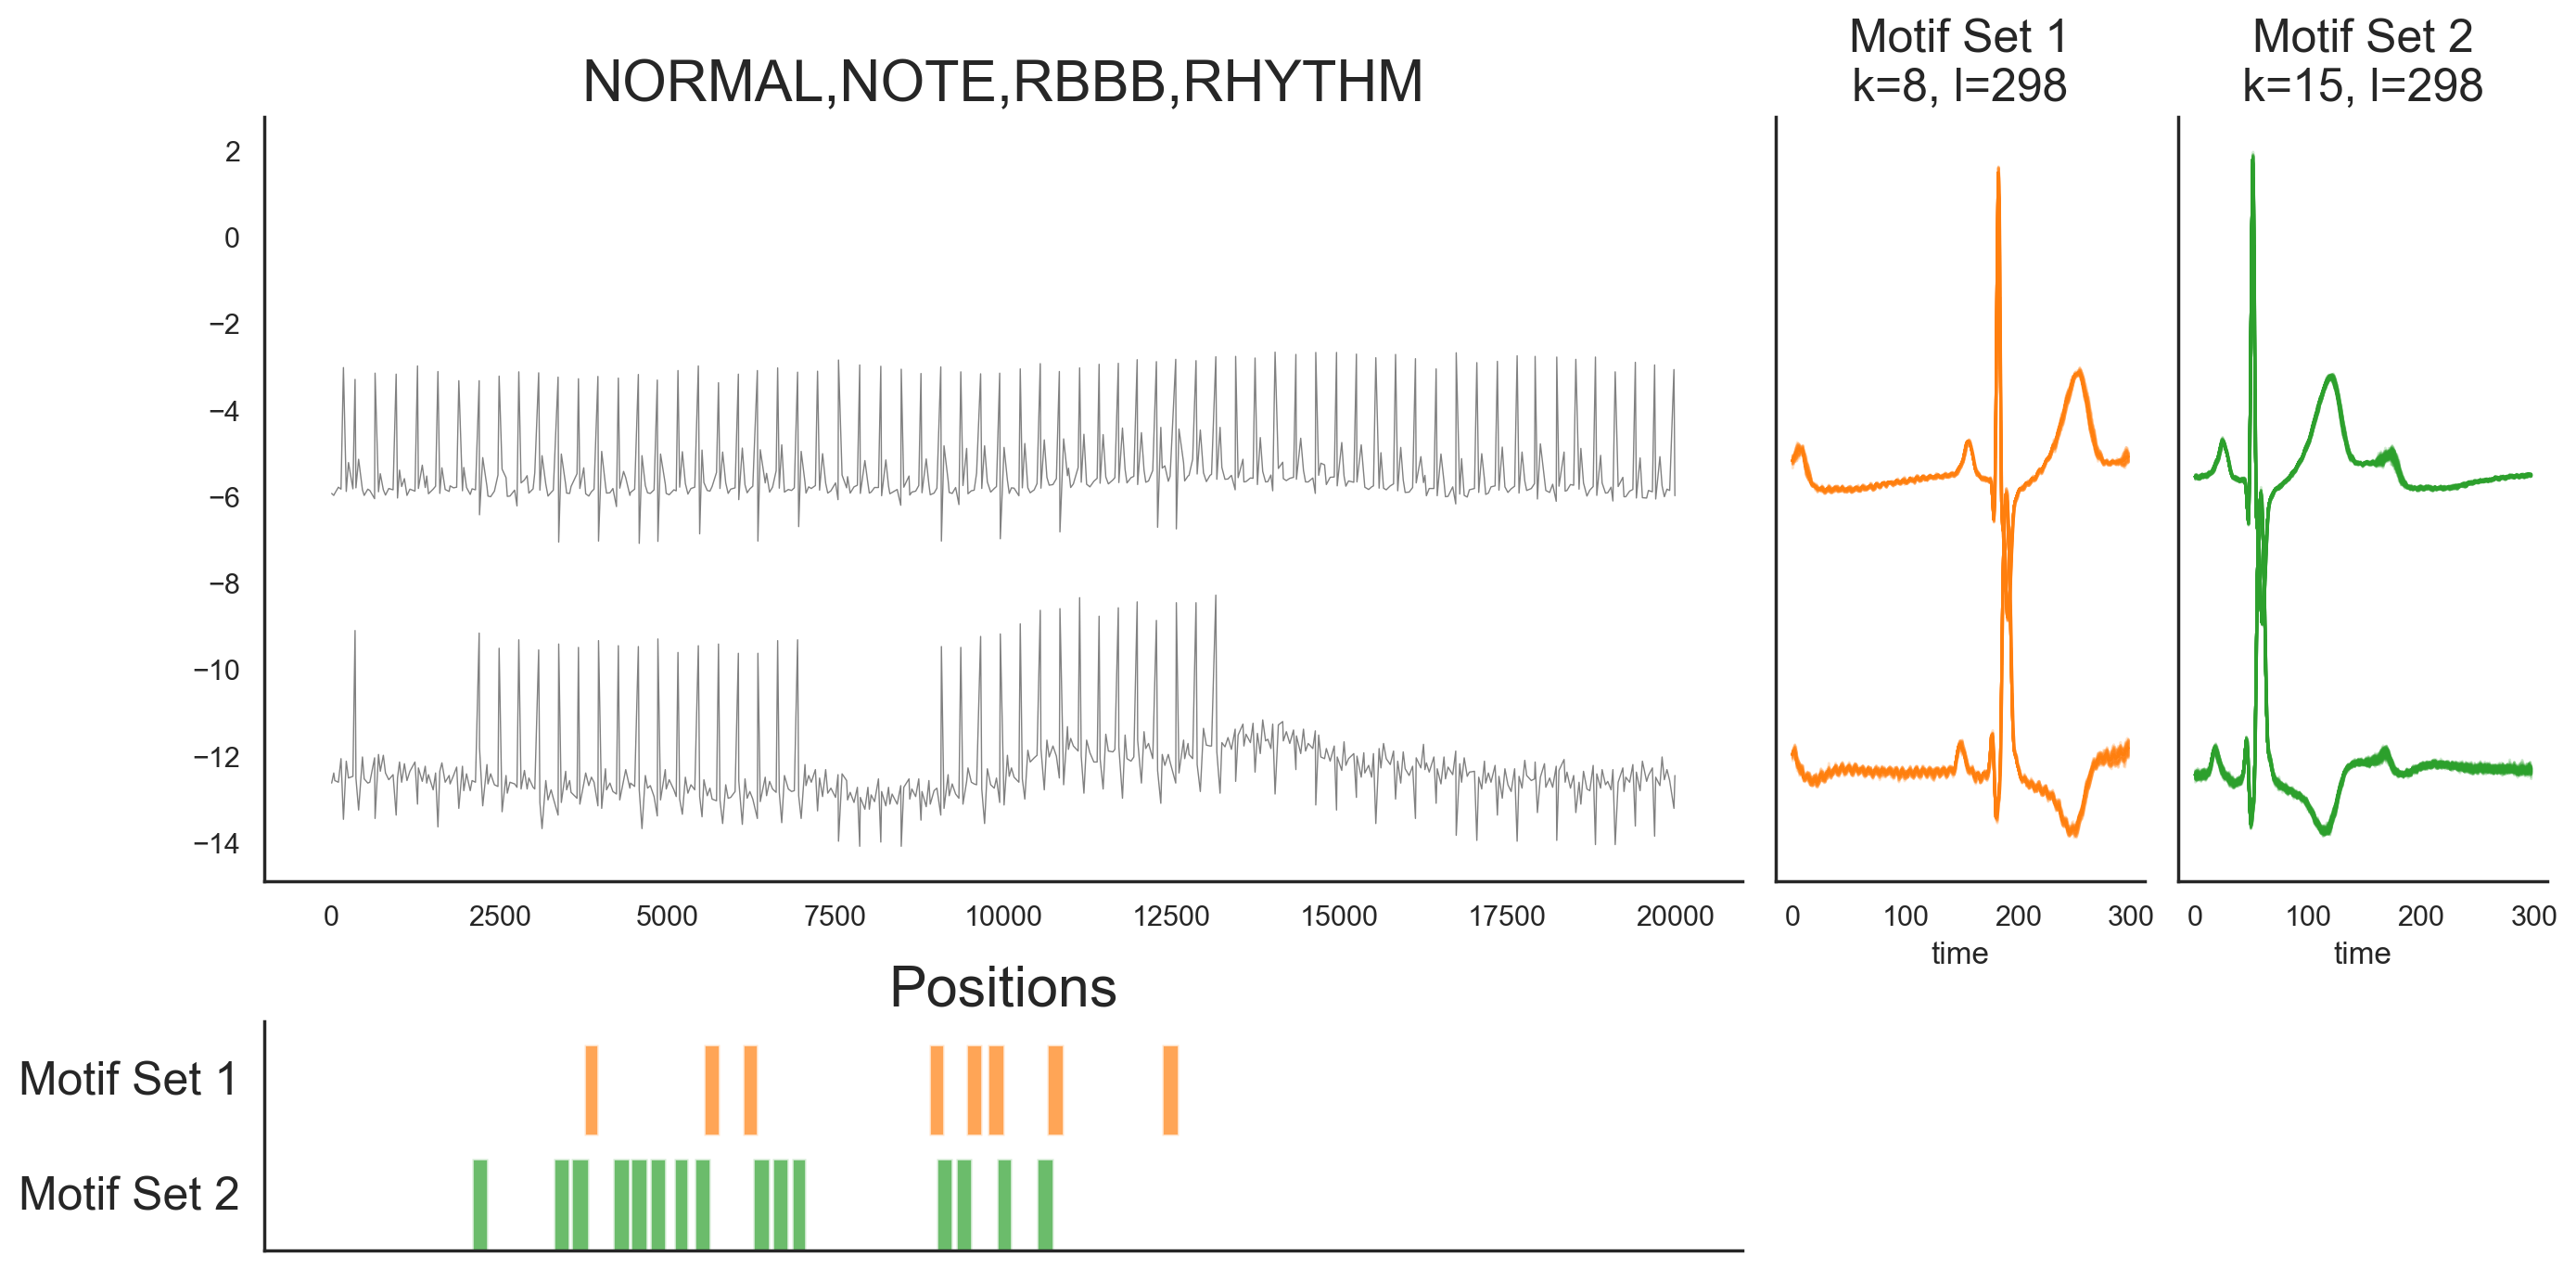

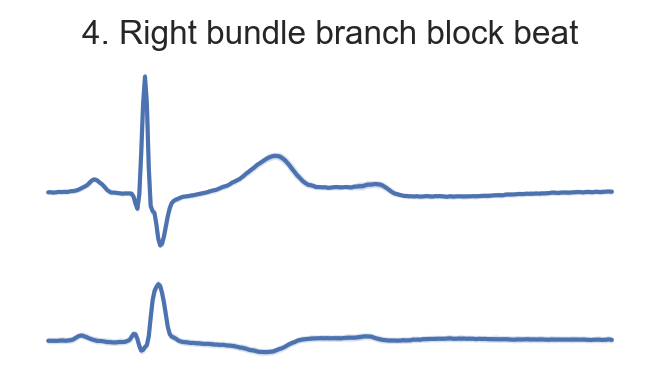

Start 101332 End 102539
Data (2, 1207)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 26
Elbow Points [ 9 16 19]  found in 0.0 s


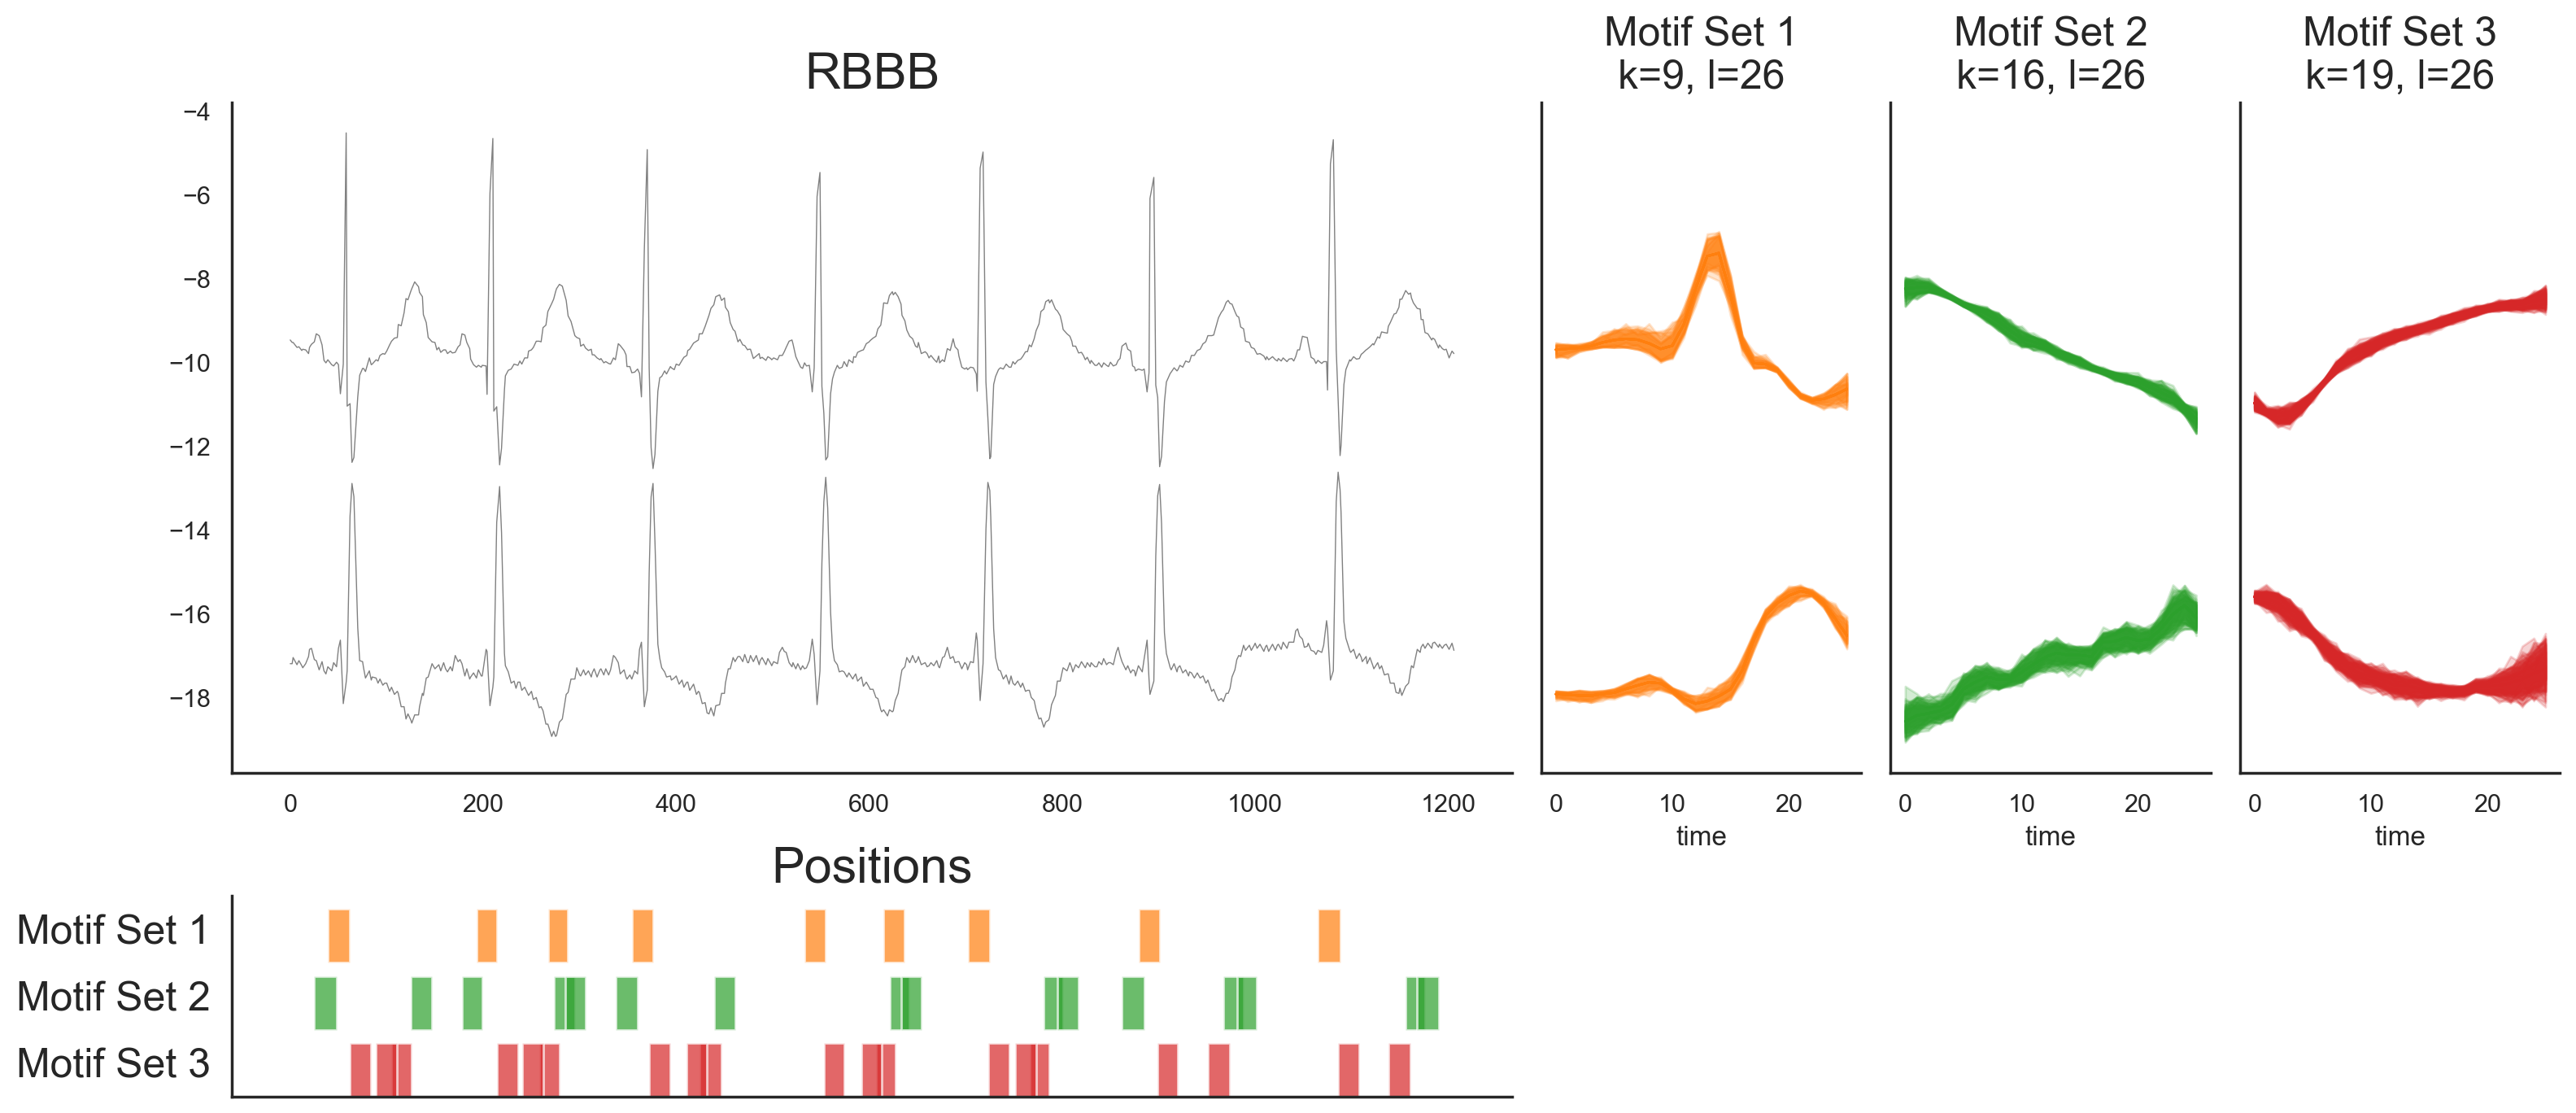

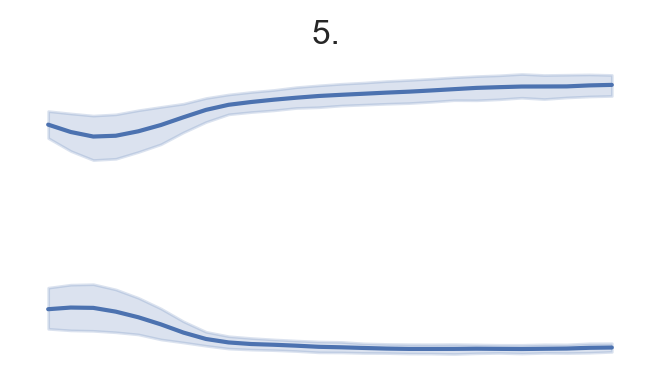

Start 102539 End 143951
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 168
Elbow Points [17 19]  found in 4.6 s


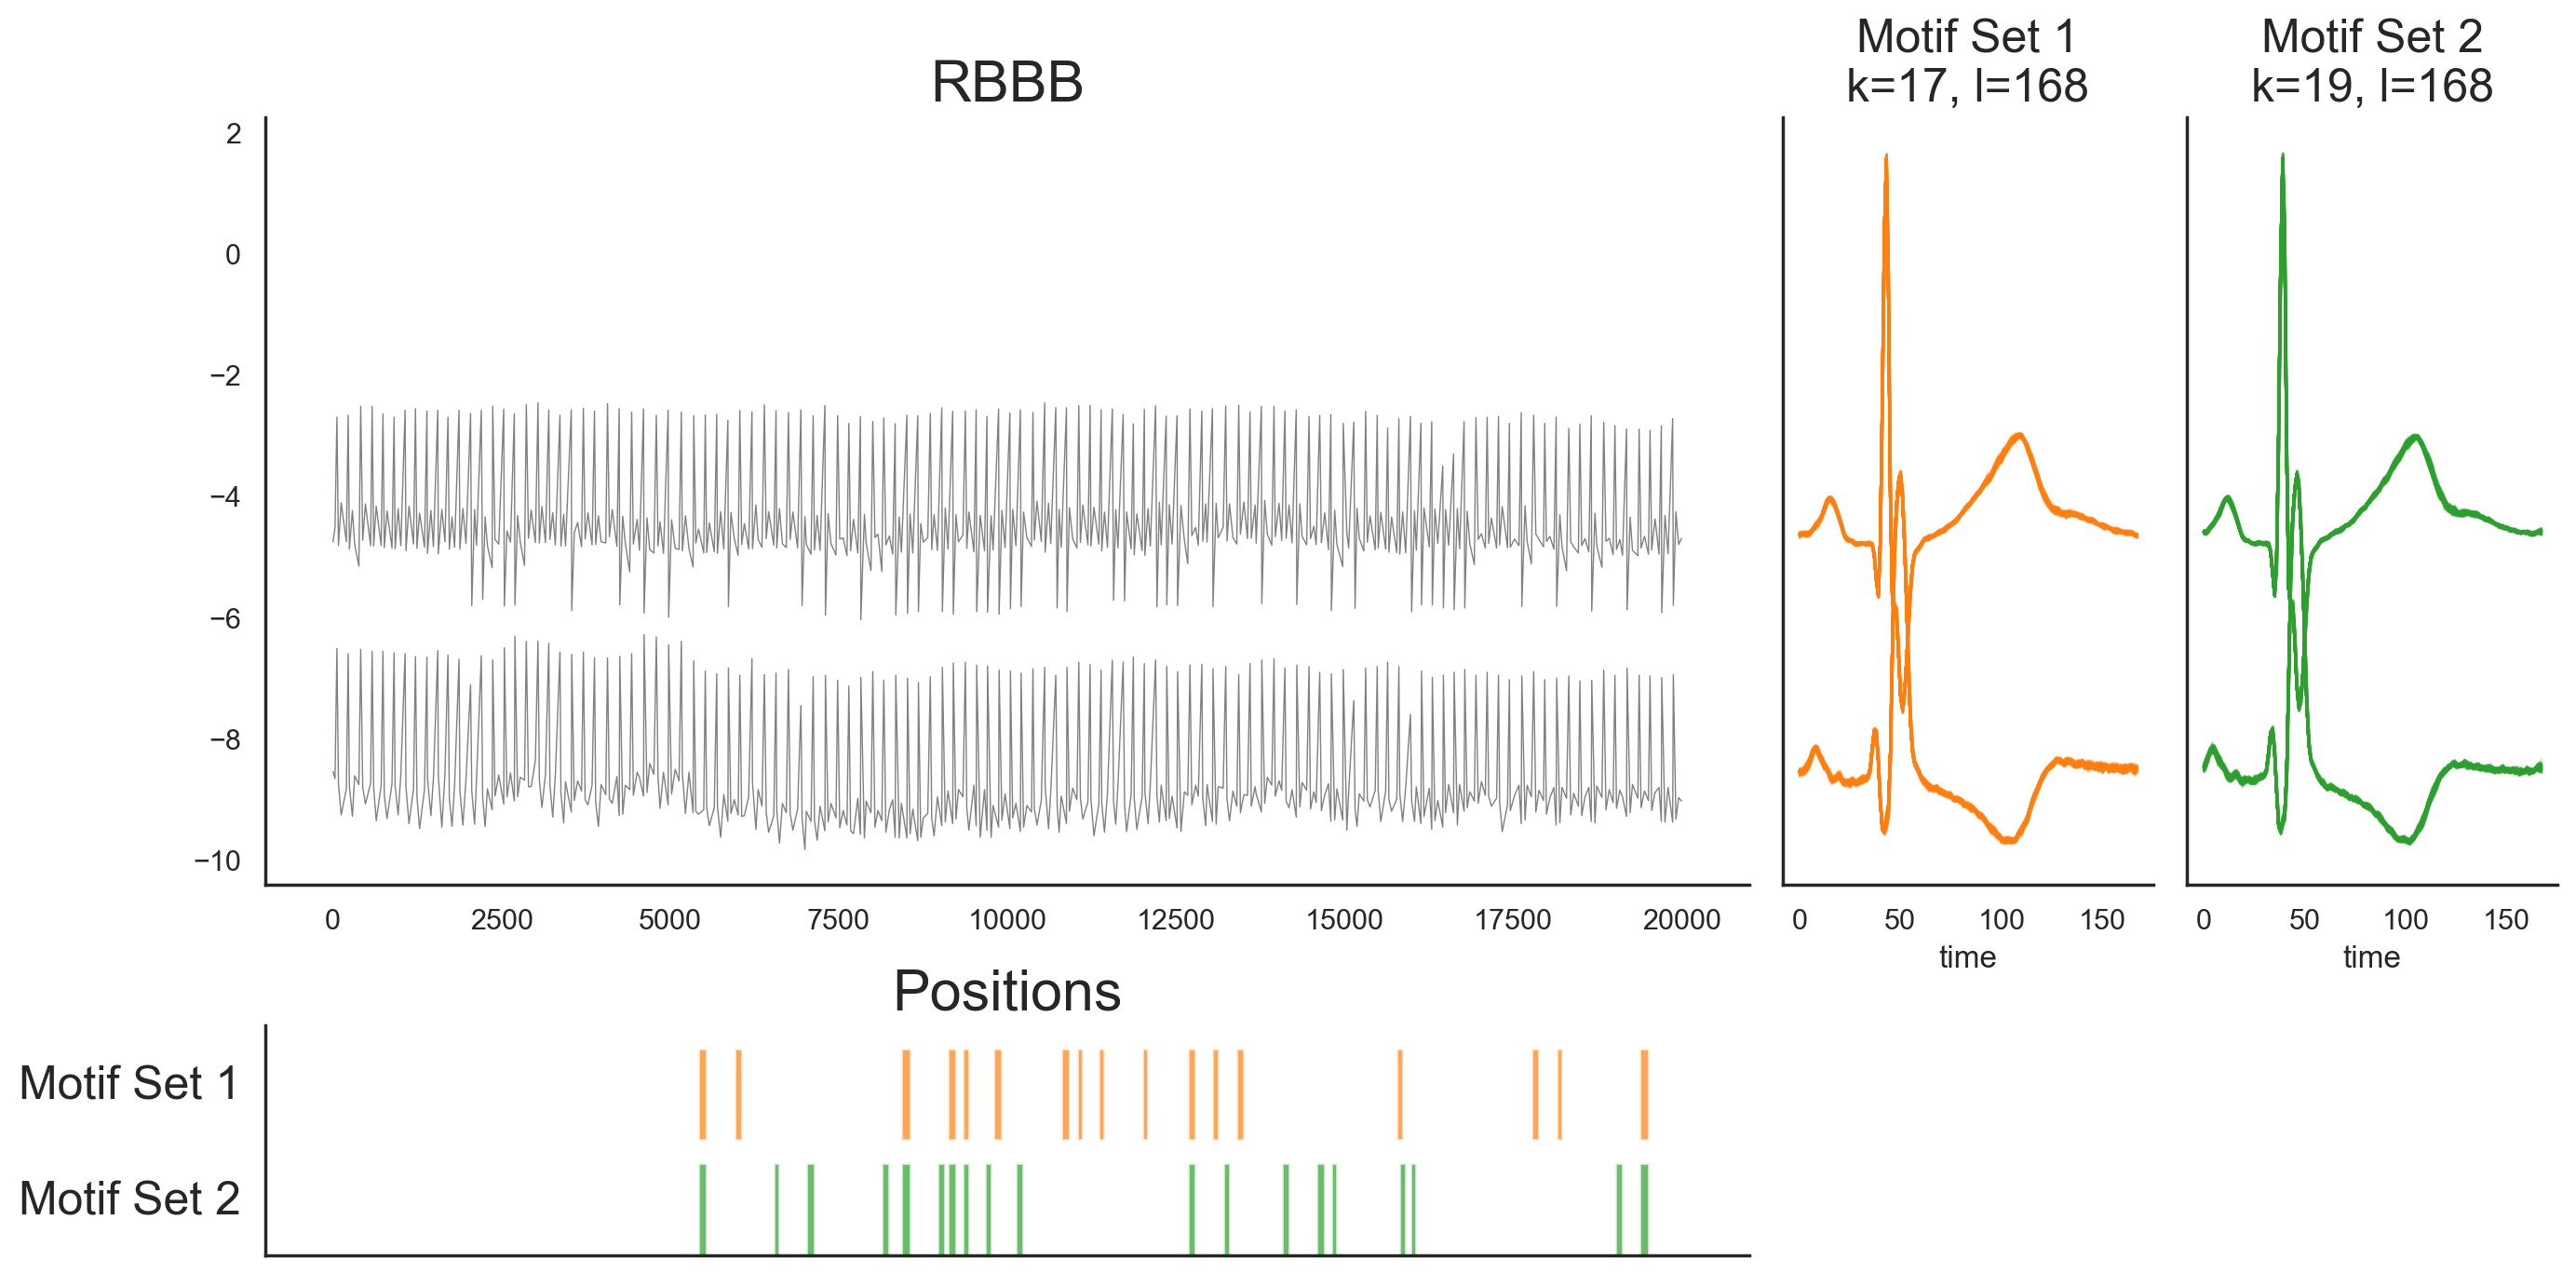

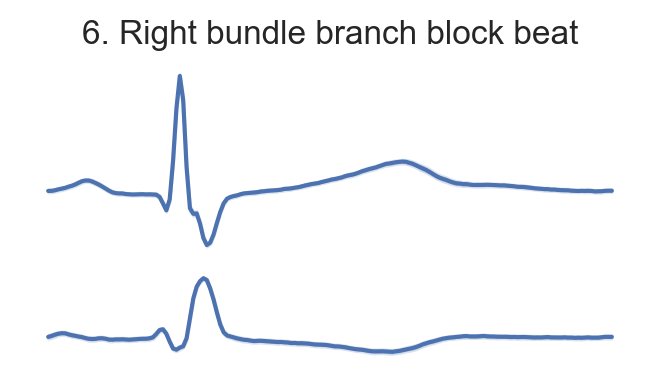

Start 143951 End 145853
Data (2, 1902)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 30
Elbow Points [15]  found in 0.1 s


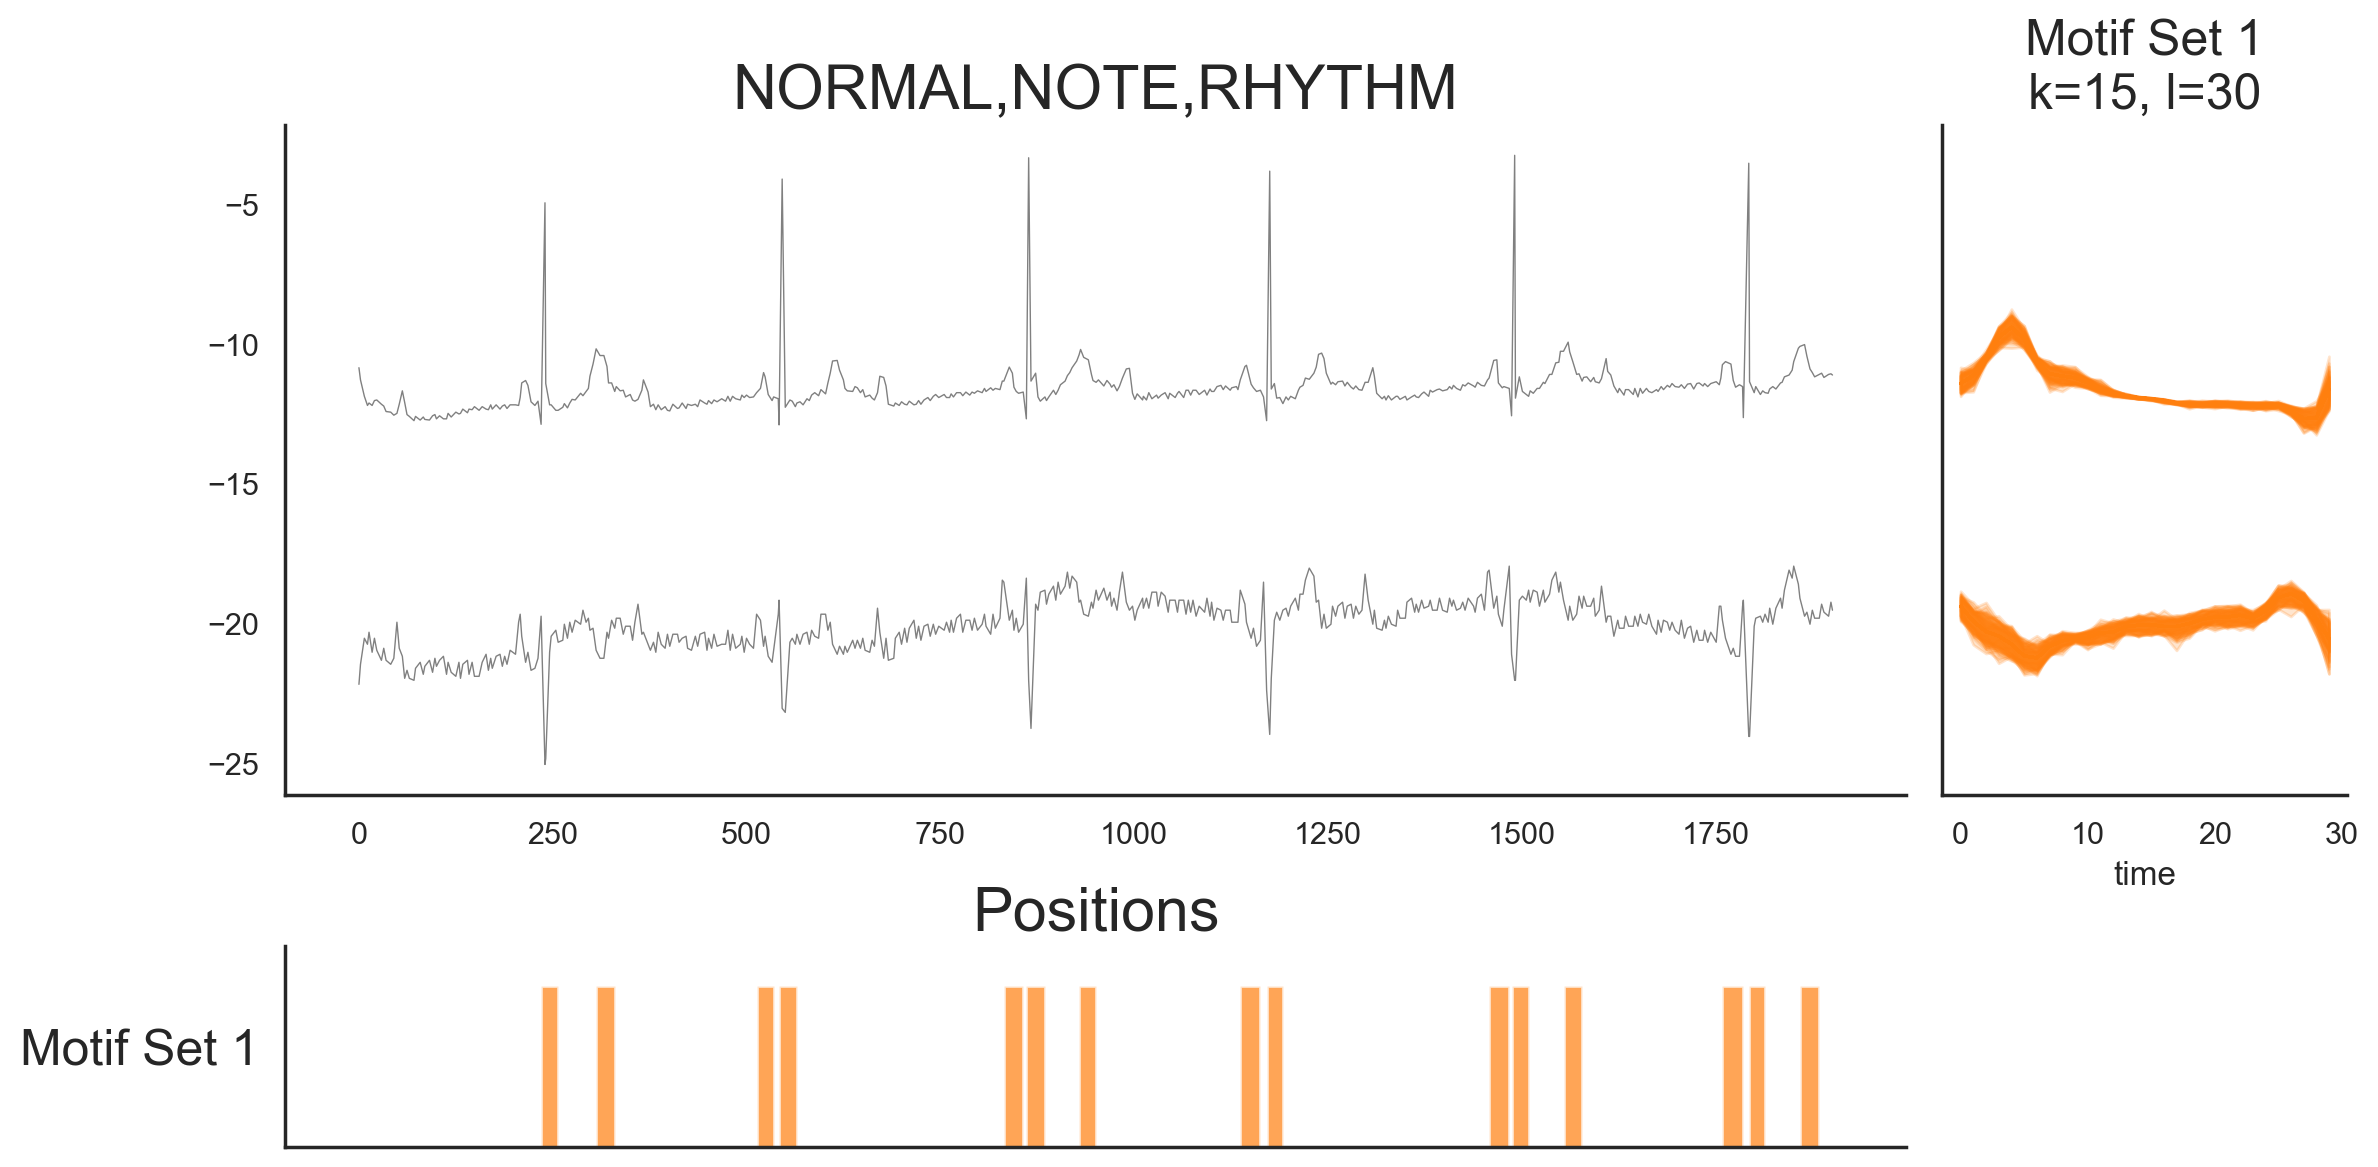

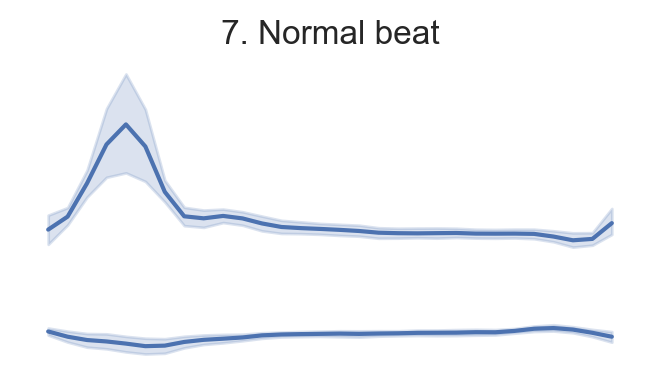

Start 145853 End 188133
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 298
Elbow Points [18]  found in 5.2 s


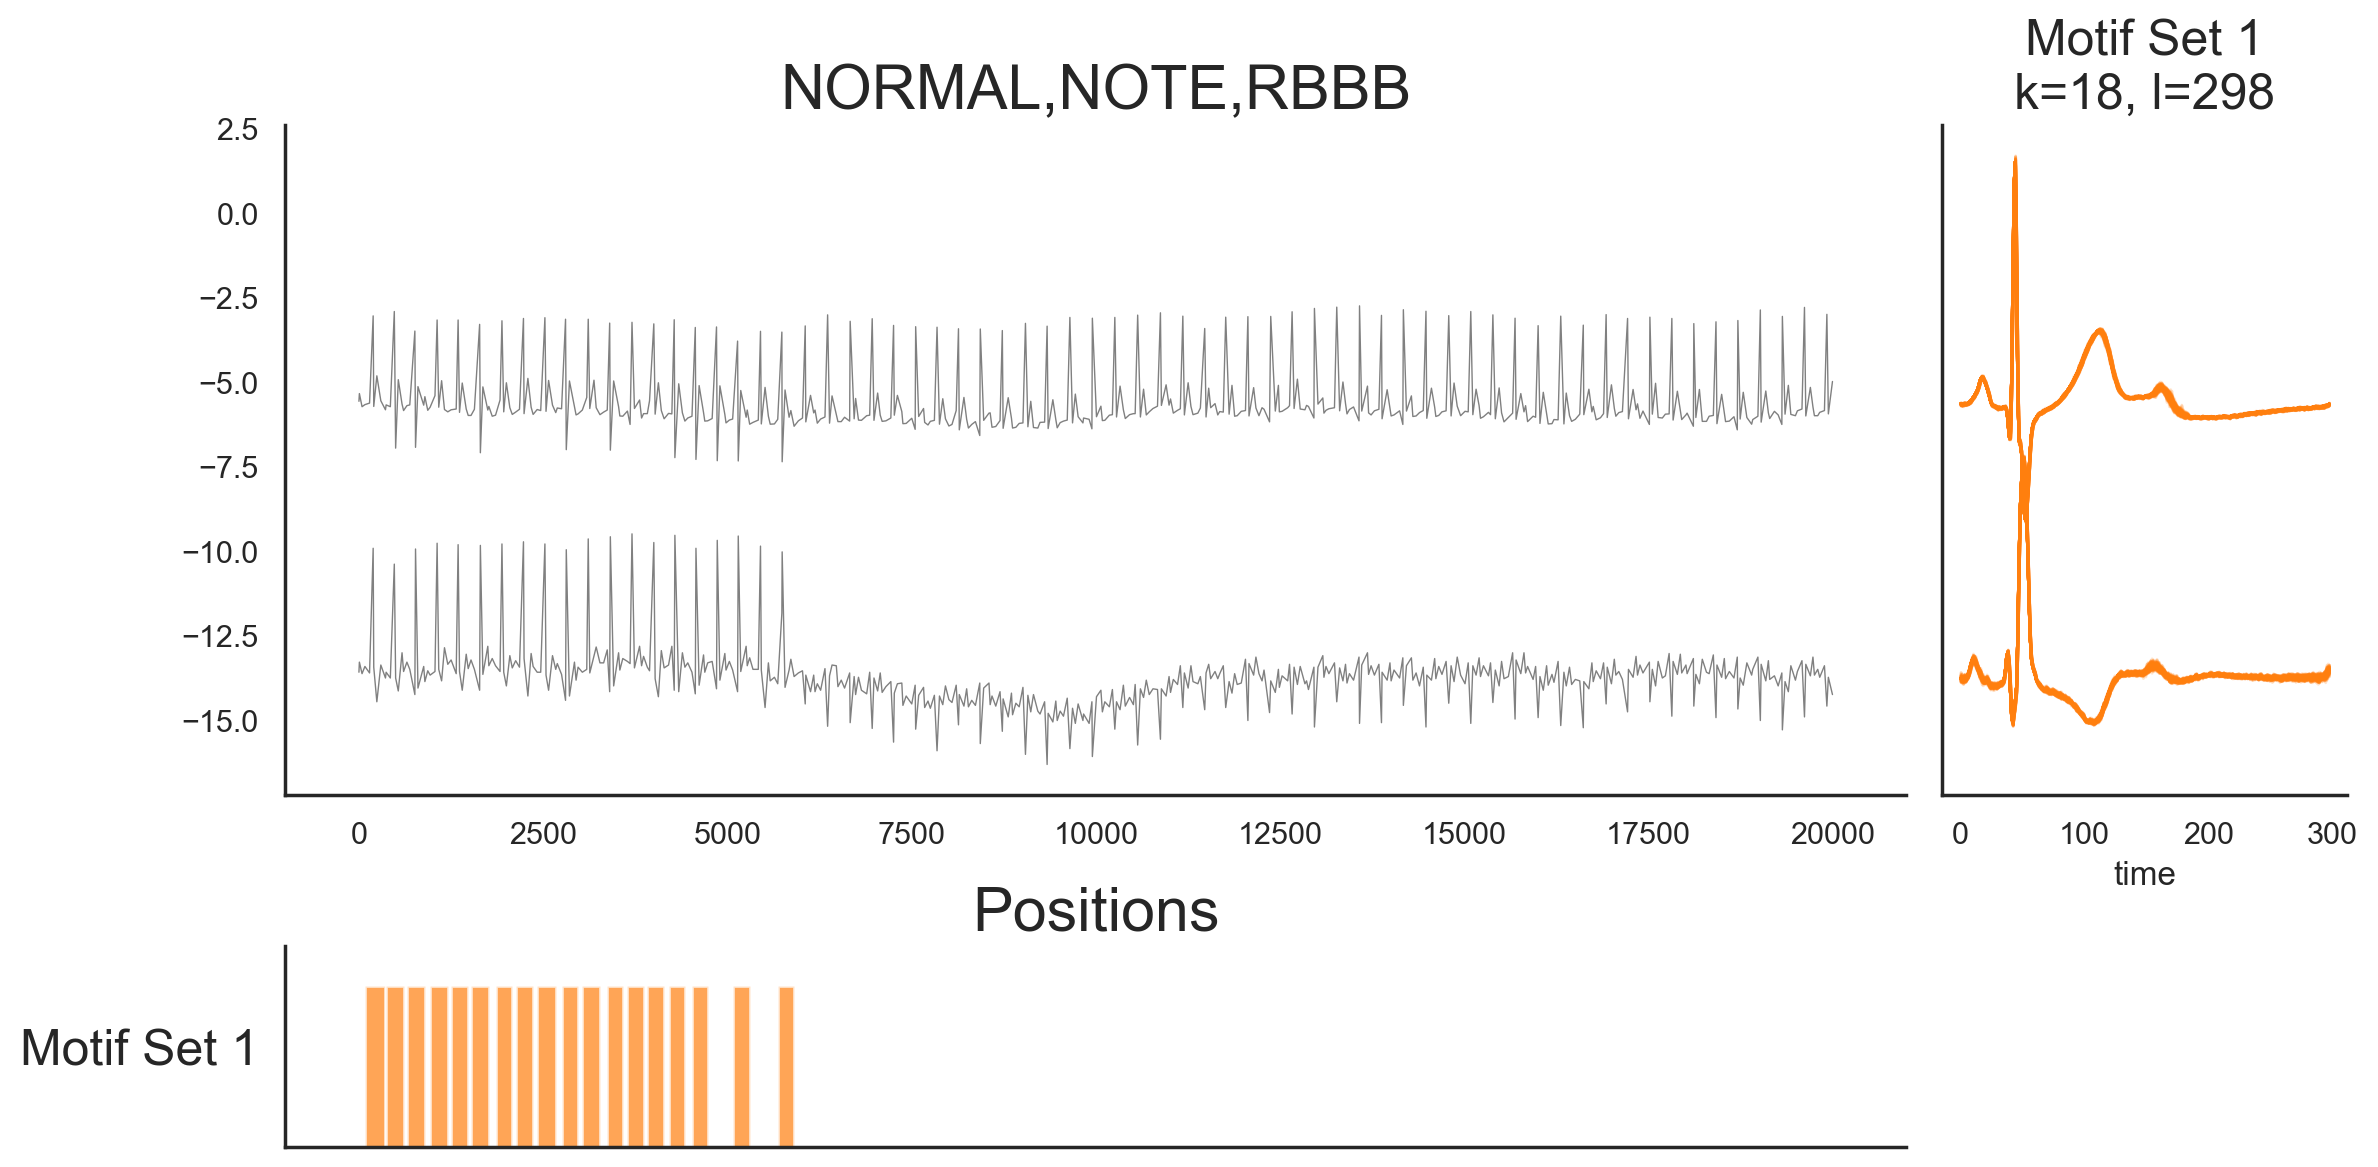

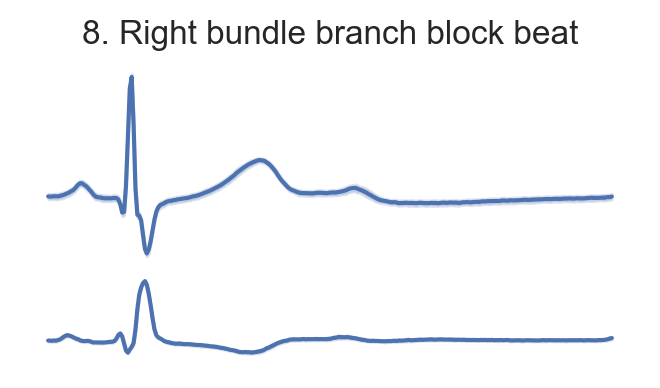

Start 188133 End 197840
Data (2, 9707)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 172
Elbow Points [12 14]  found in 0.5 s


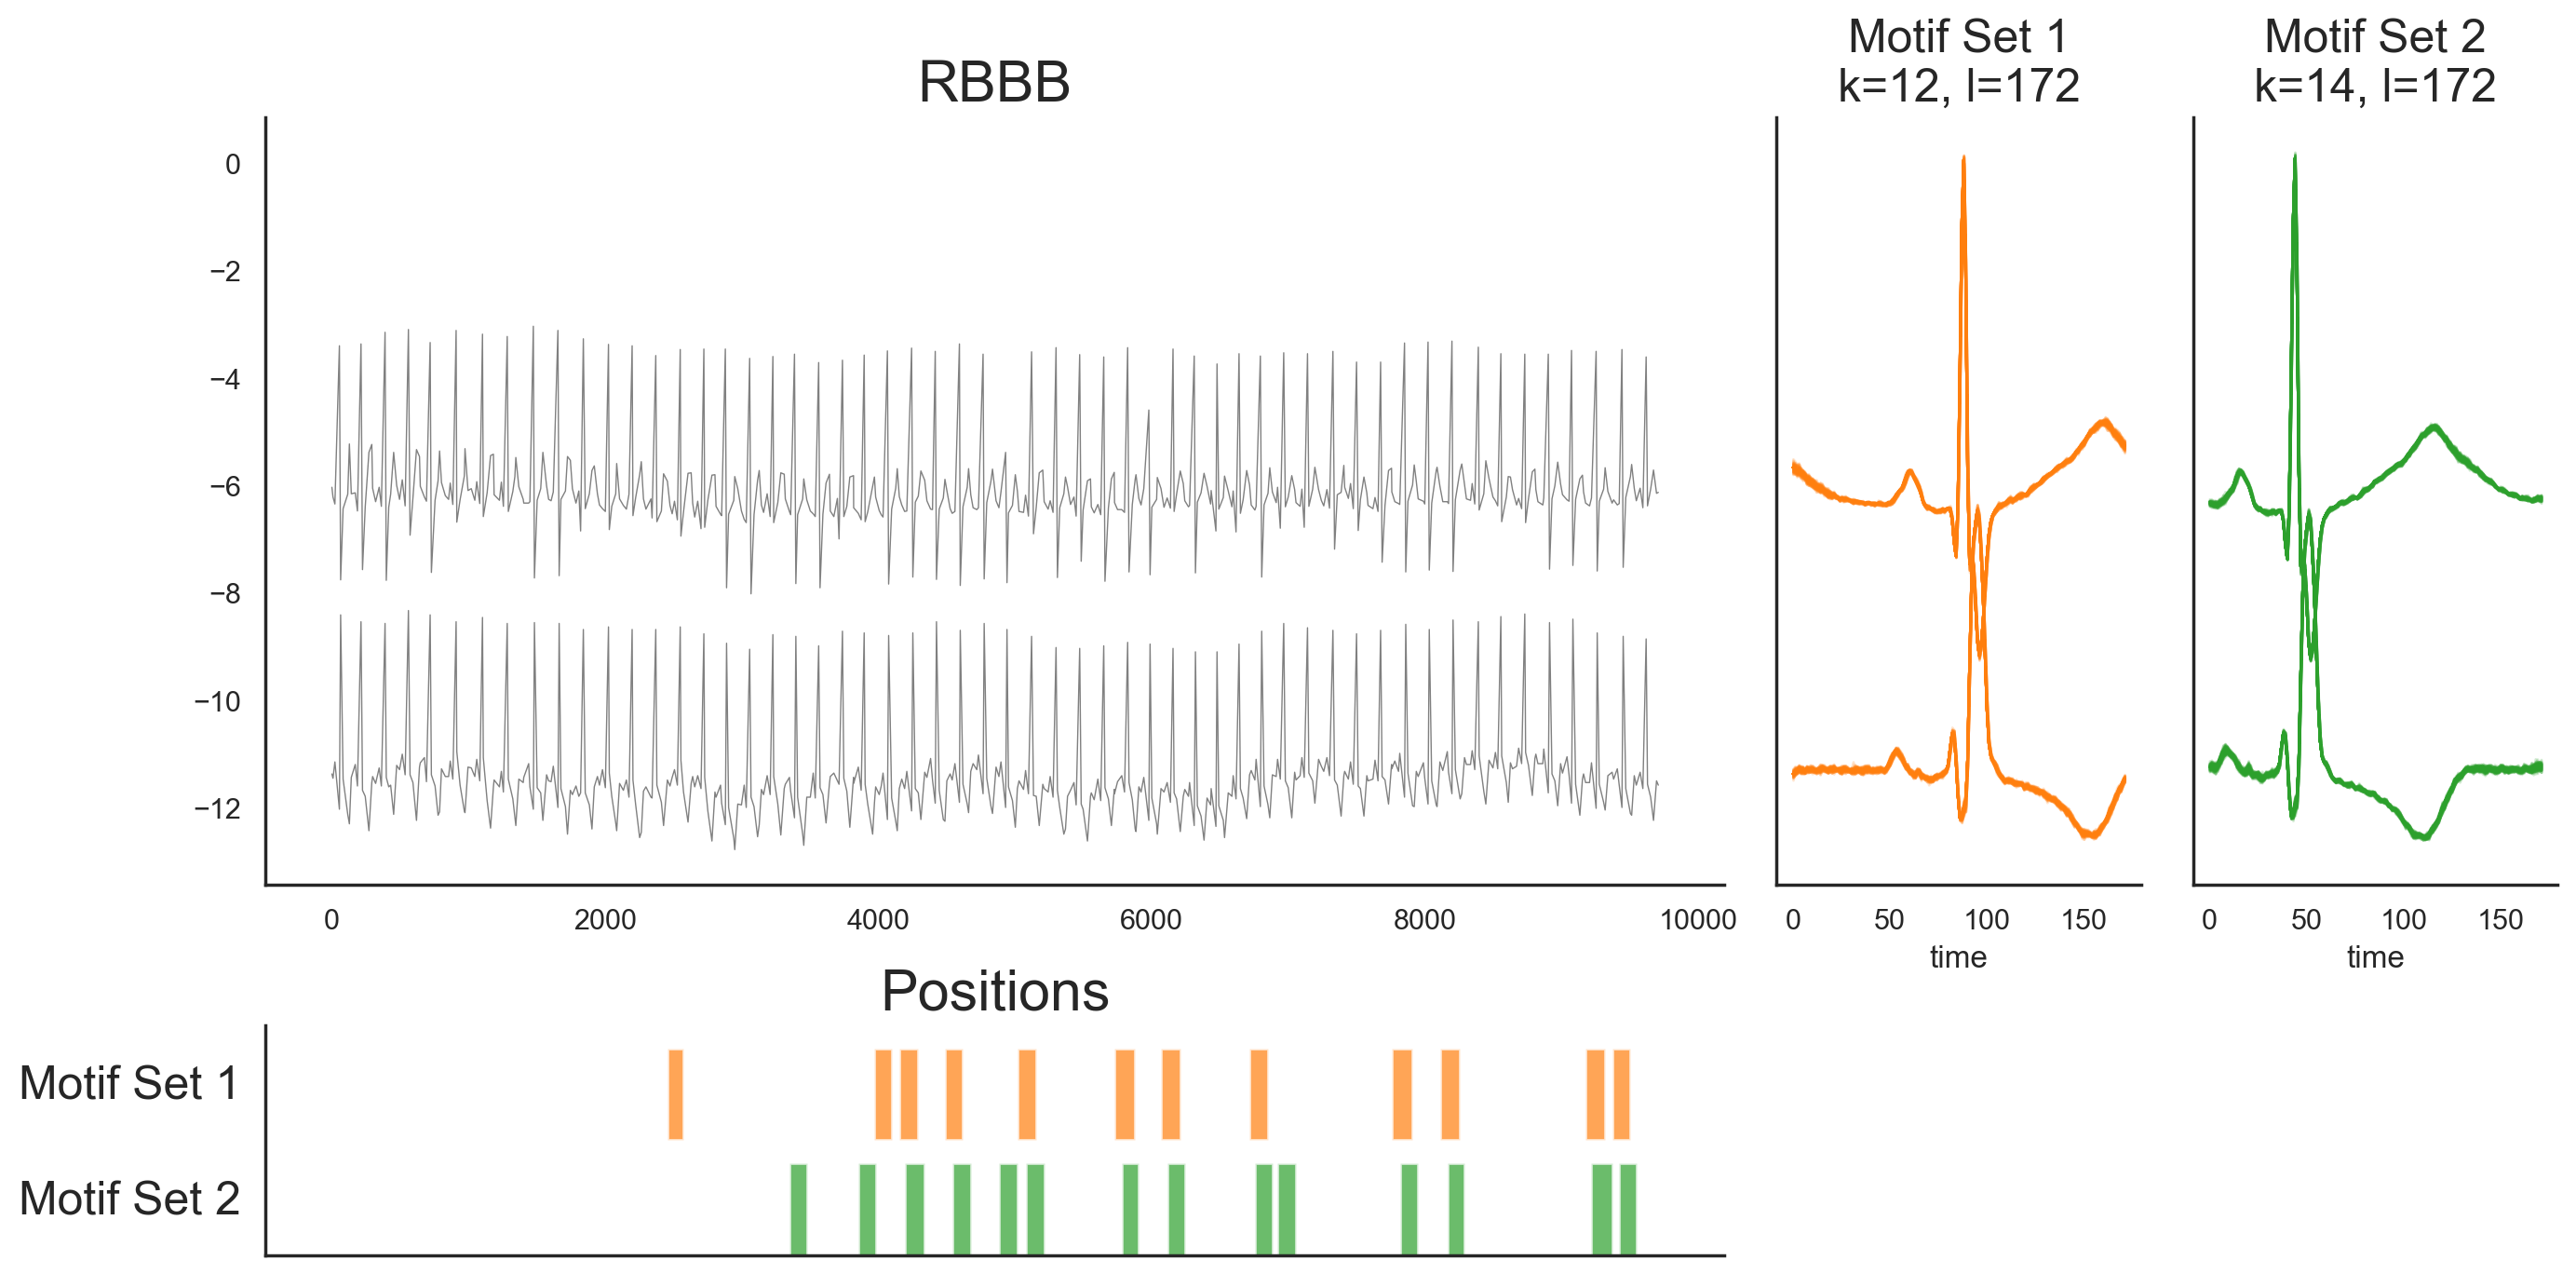

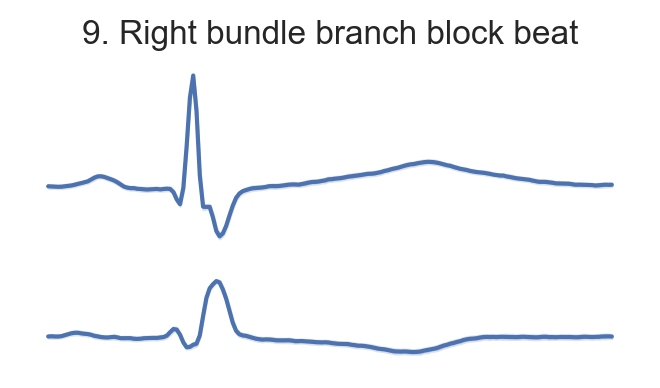

Start 197840 End 216644
Data (2, 18804)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 174
Elbow Points [16]  found in 4.1 s


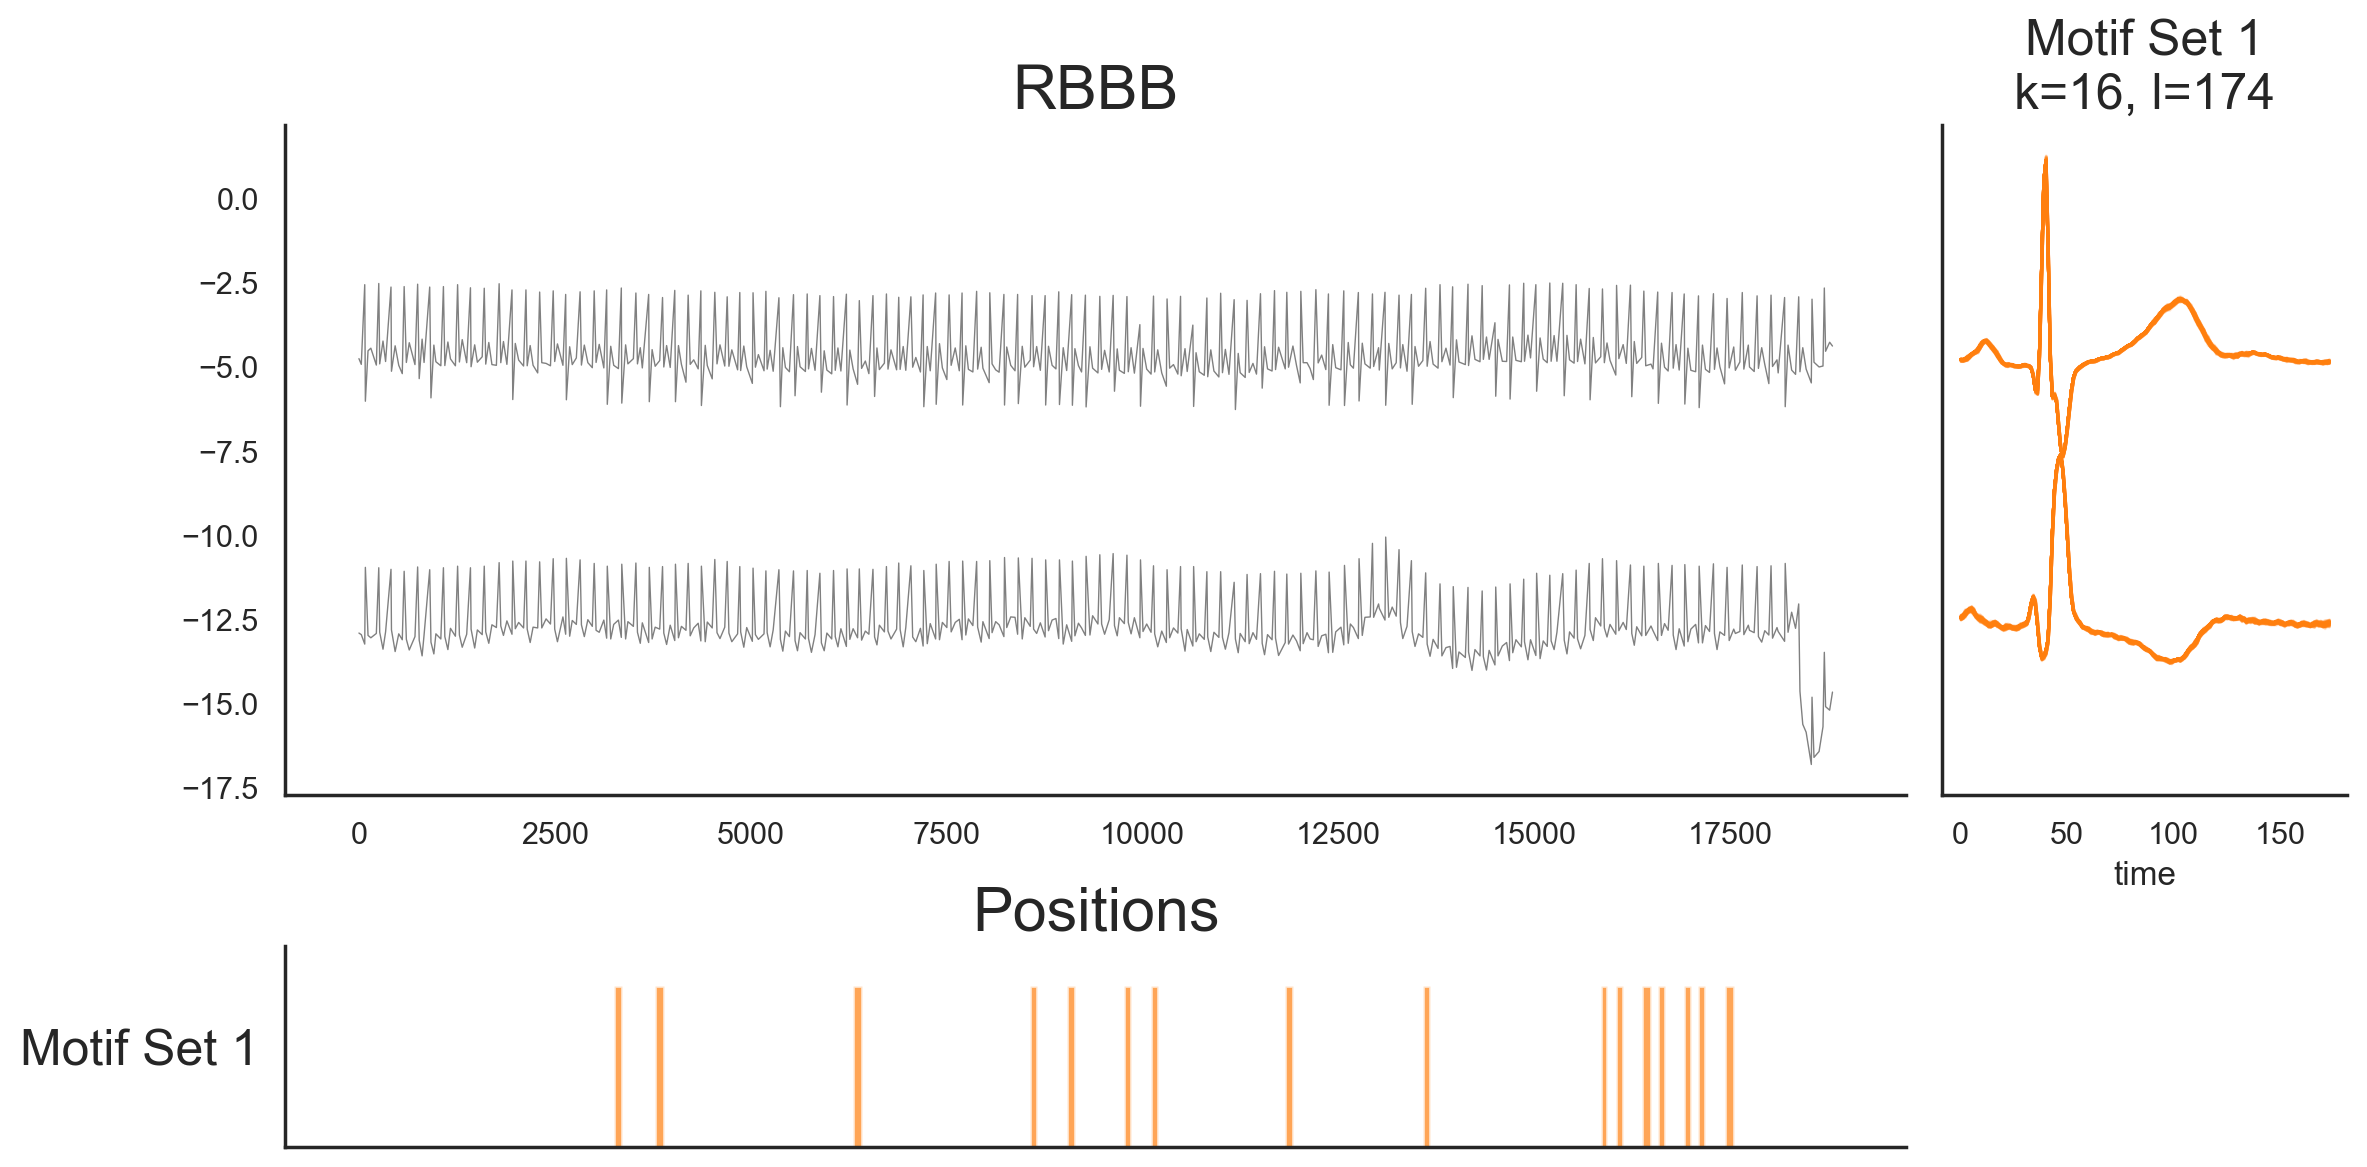

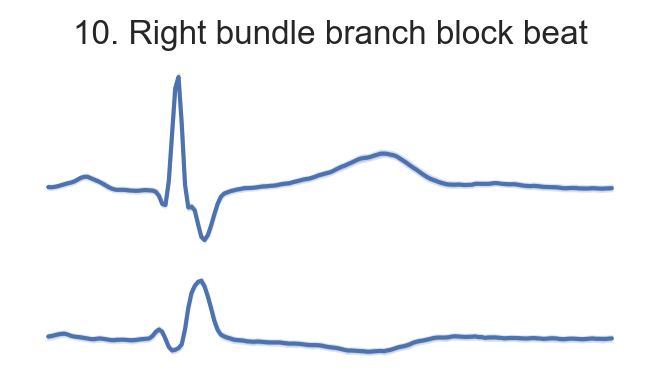

Start 216644 End 224515
Data (2, 7871)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 148
Elbow Points [19]  found in 0.6 s


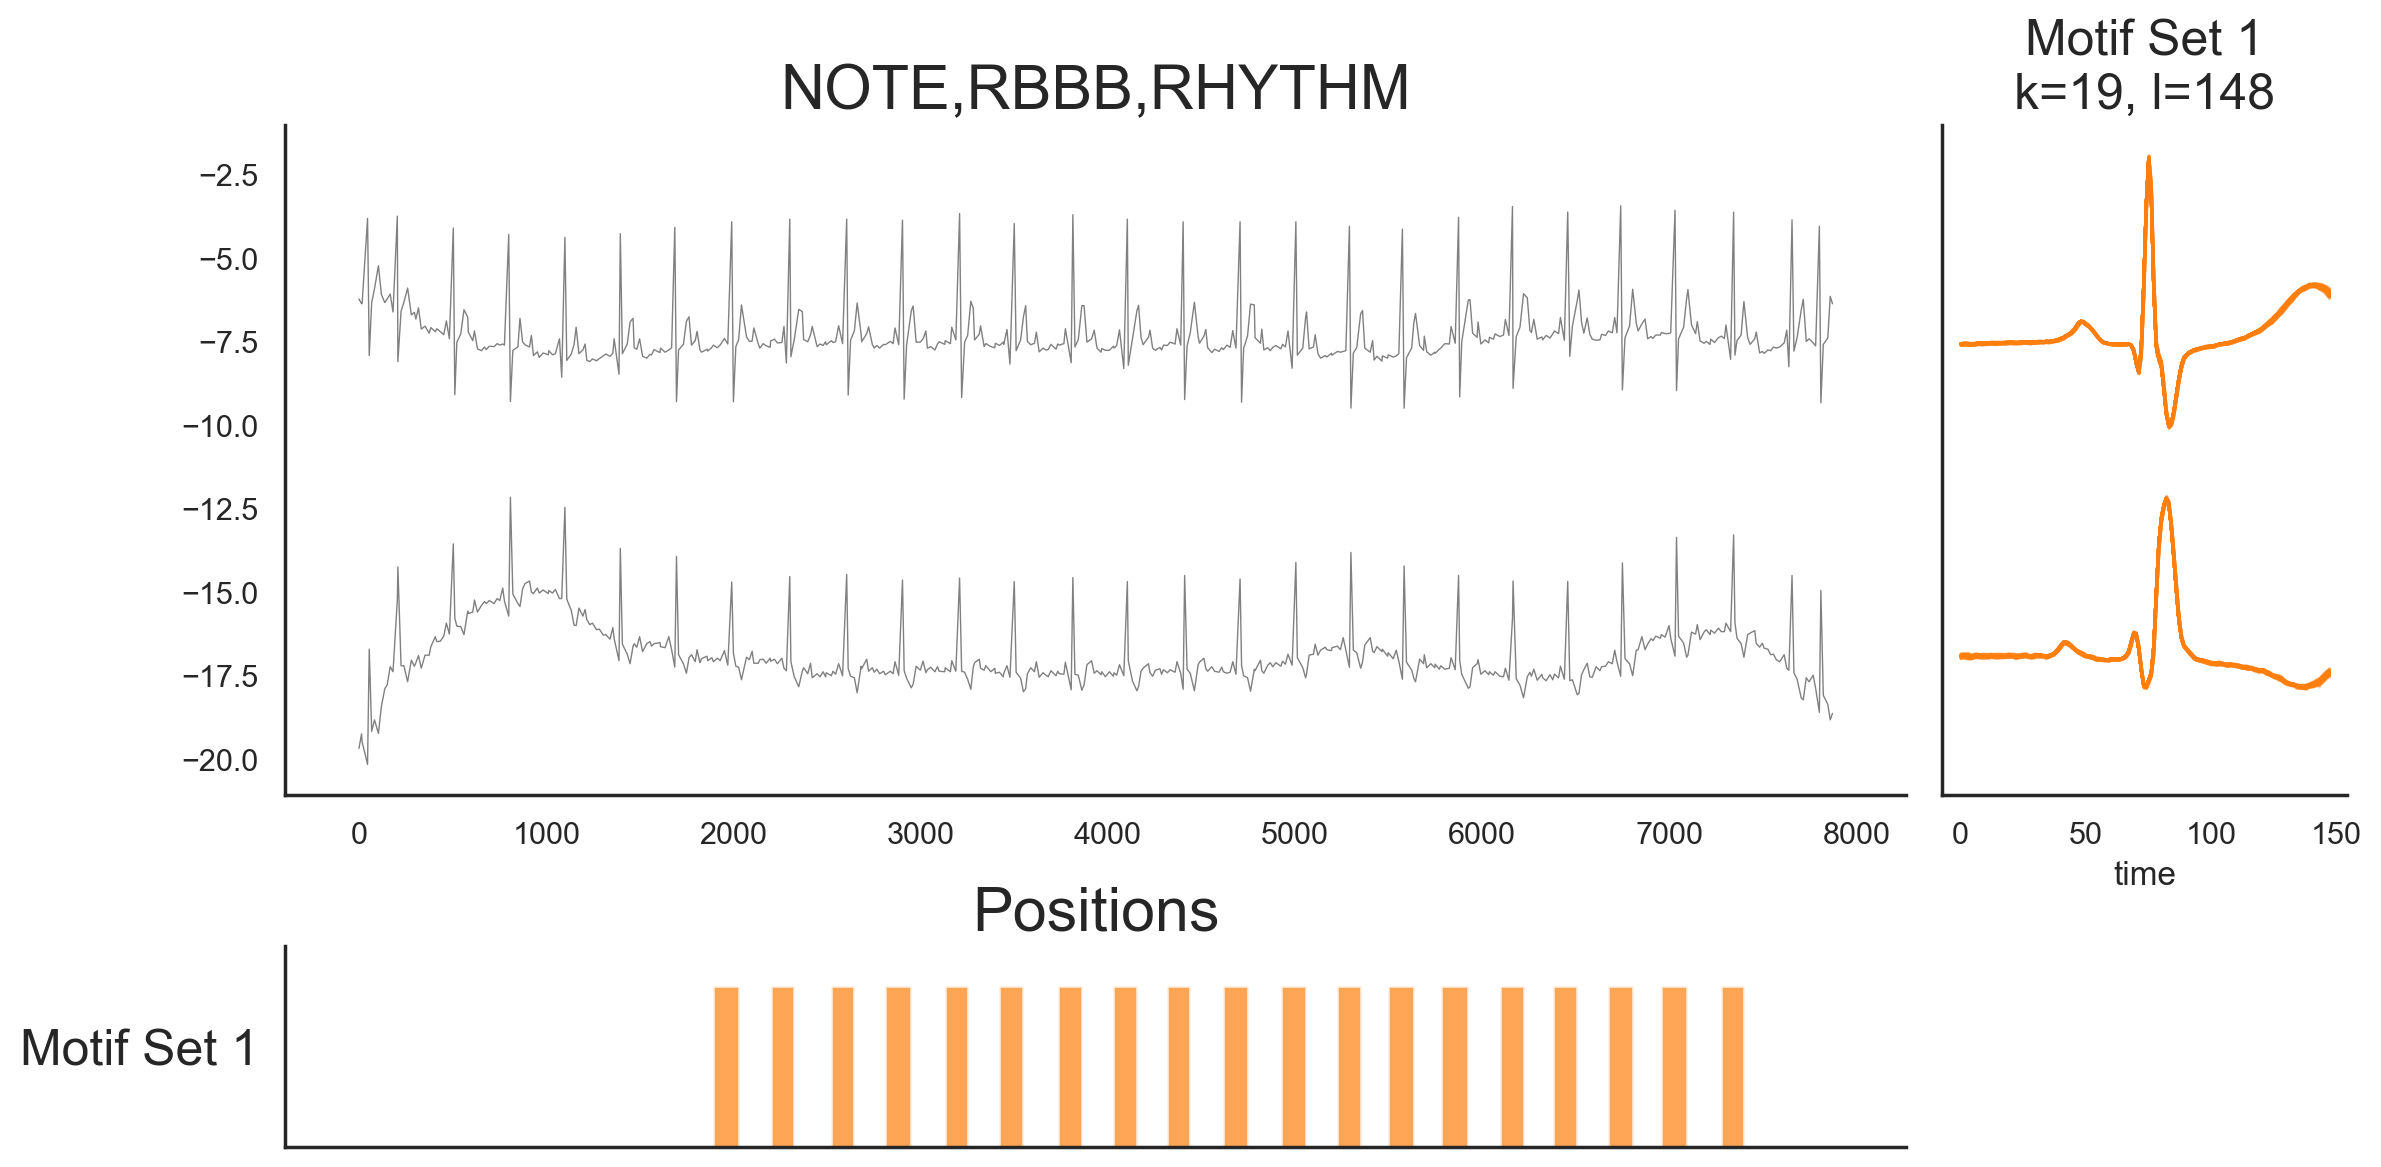

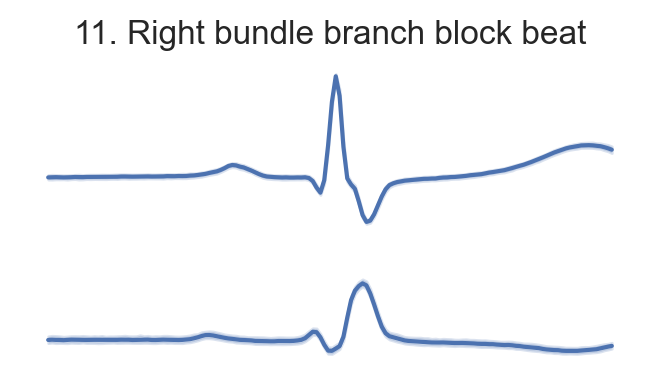

Start 224515 End 229413
Data (2, 4898)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 168
Elbow Points [15]  found in 0.2 s


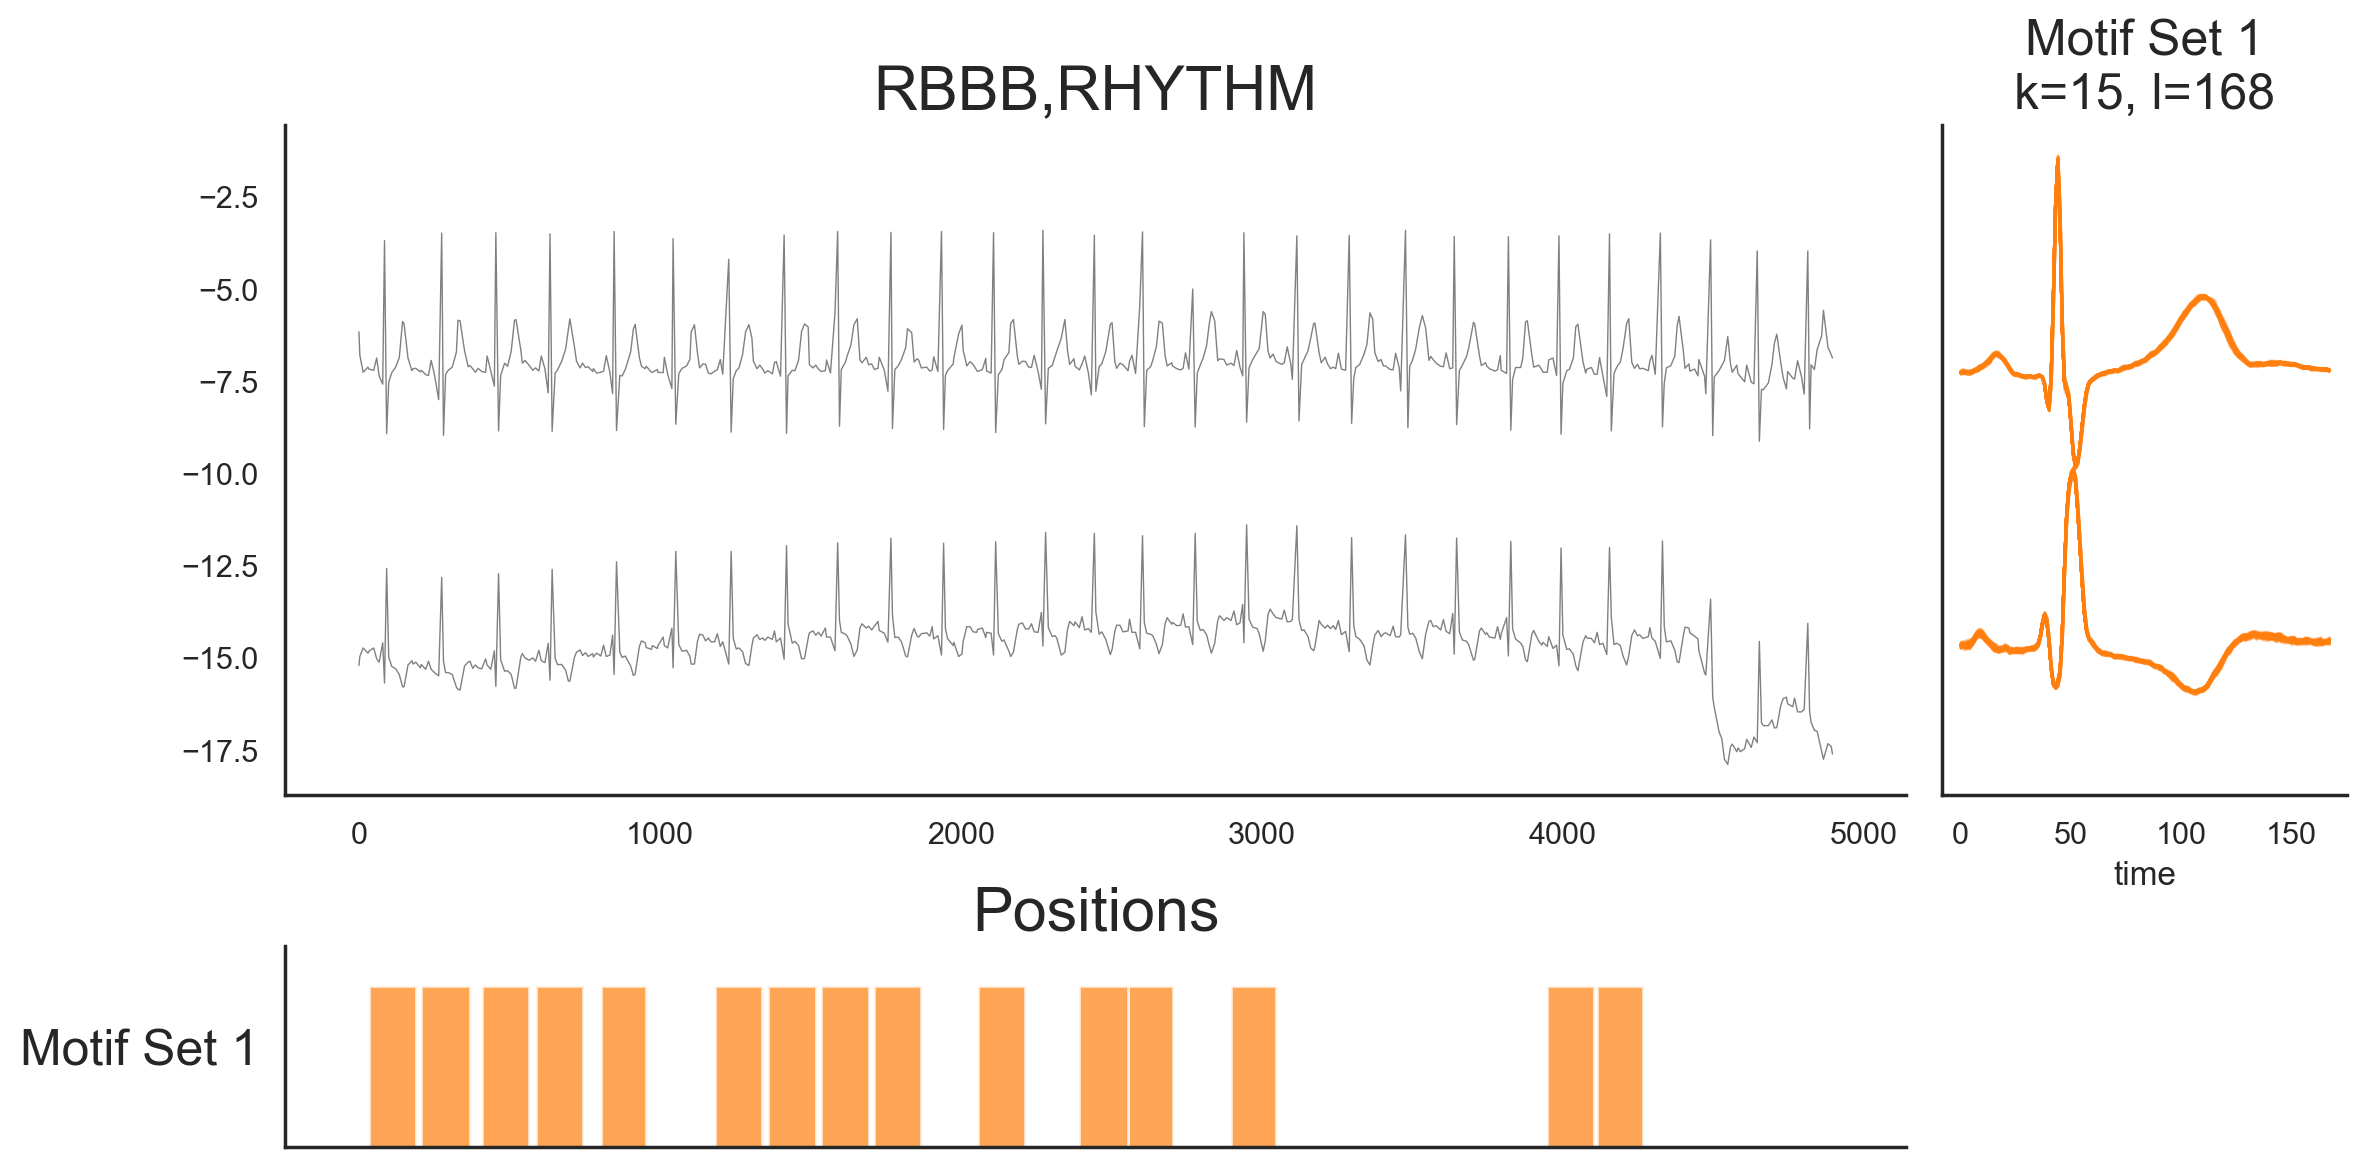

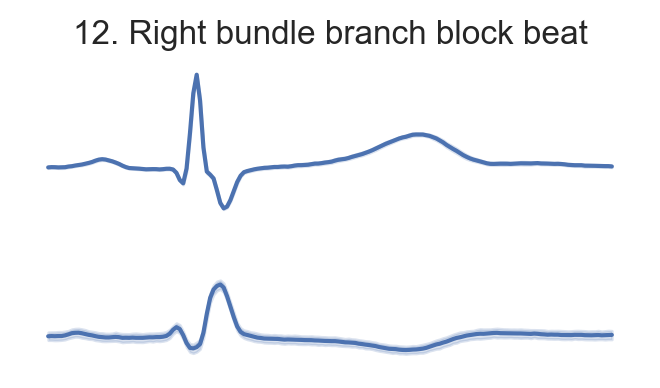

Start 229413 End 253874
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 302
Elbow Points [15 17 19]  found in 6.2 s


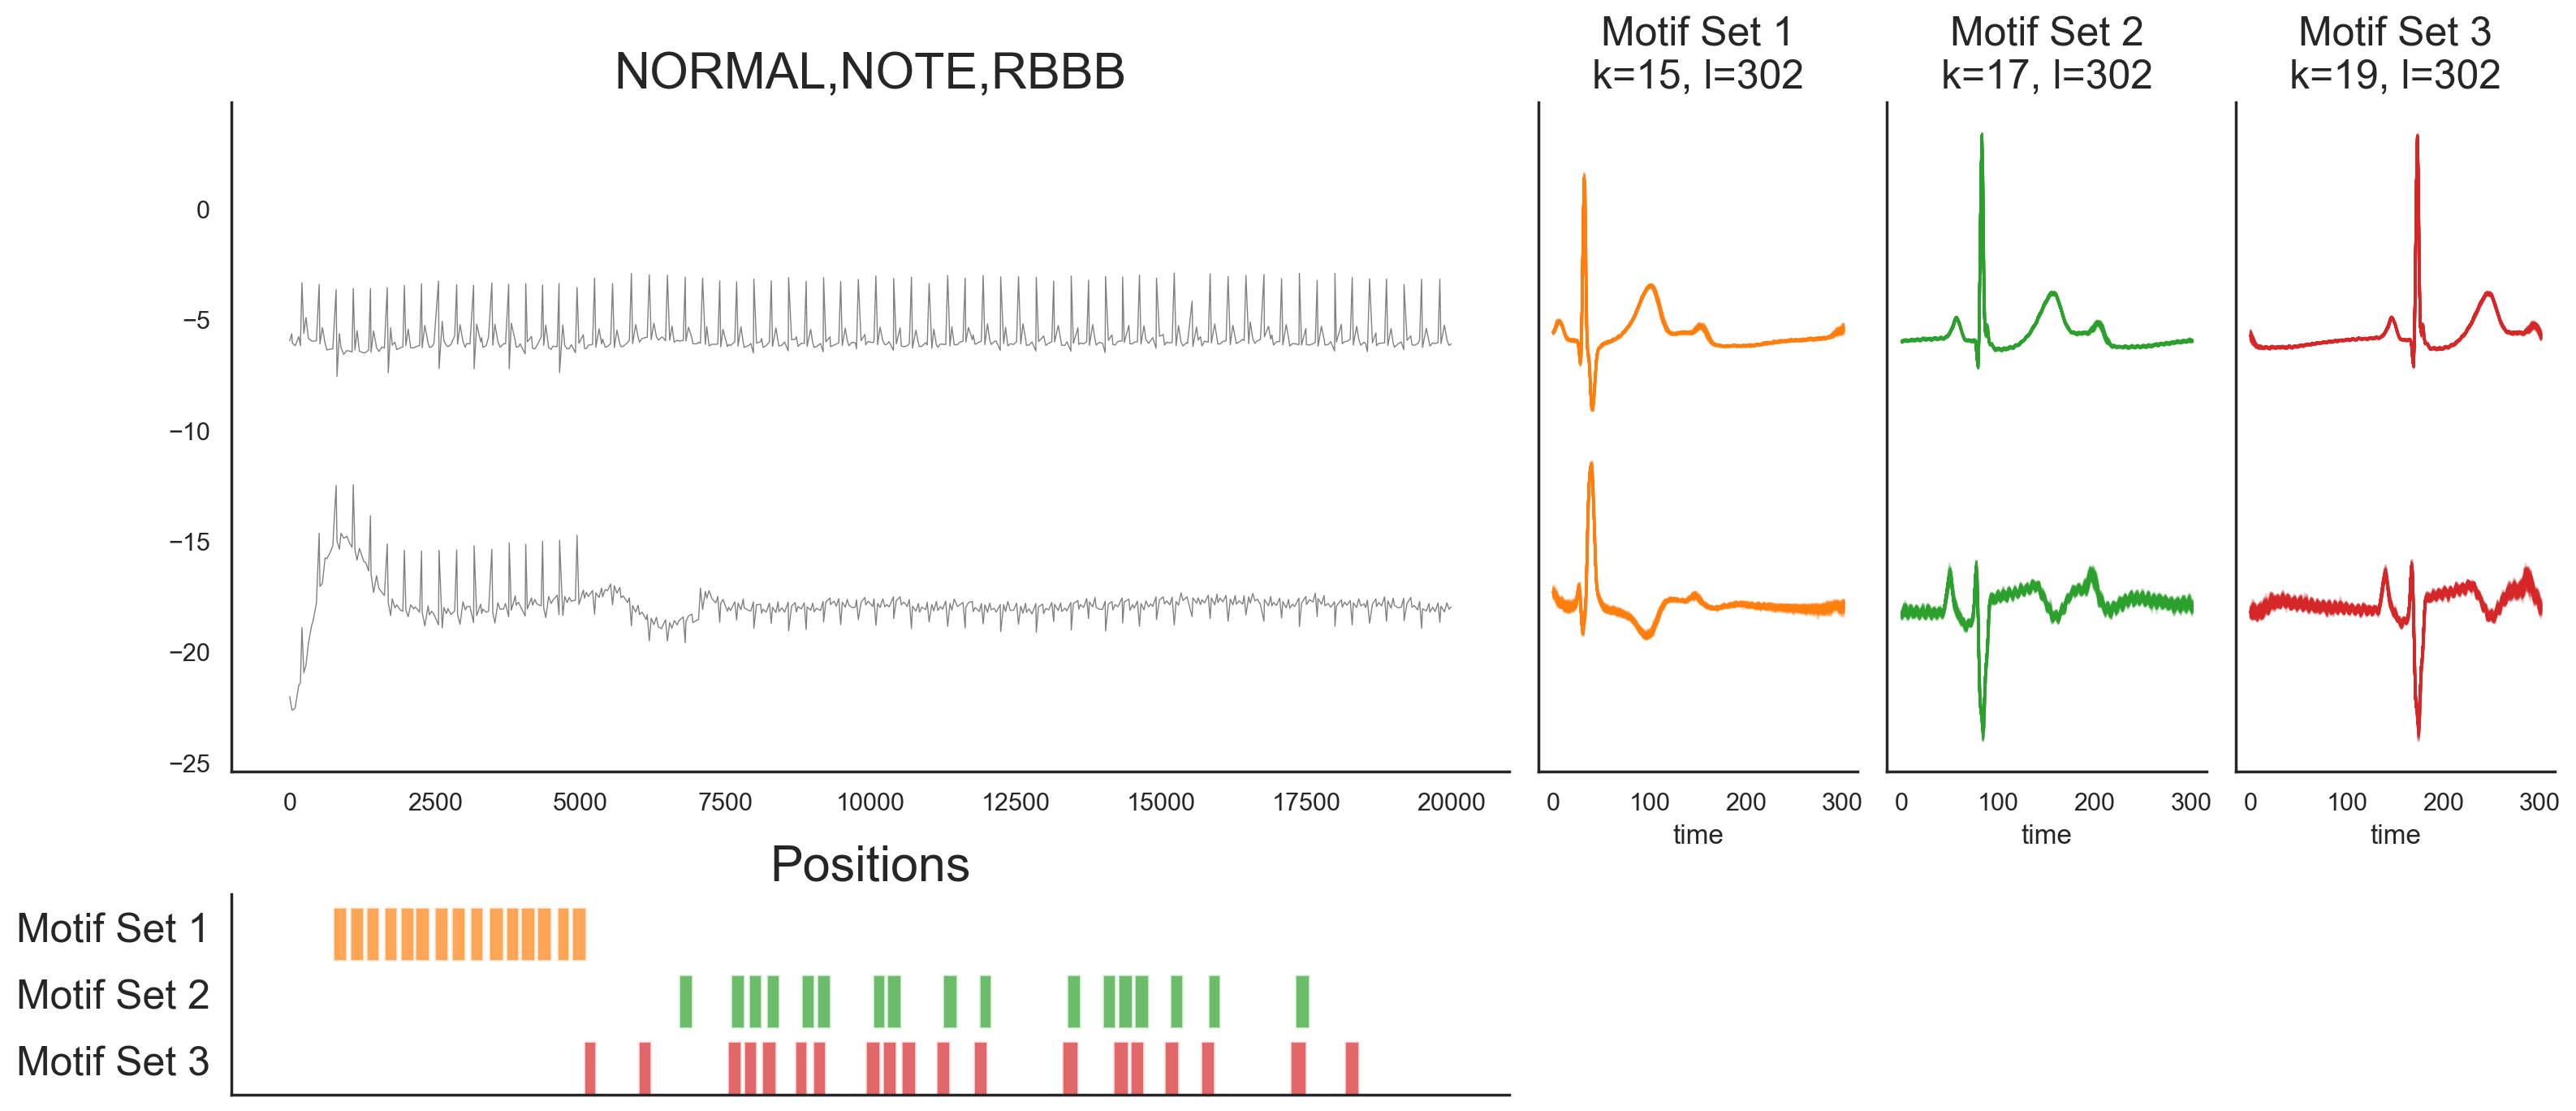

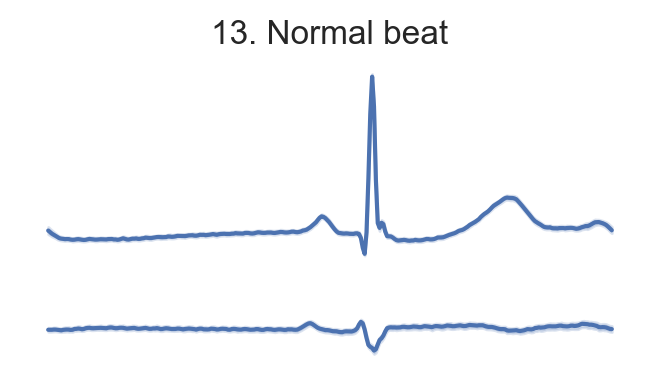

Start 253874 End 325000
Data (2, 20000)


Compute ks (20):   0%|          | 0/19 [00:00<?, ?it/s]

Window-size: 178
Elbow Points [13 16 19]  found in 4.2 s


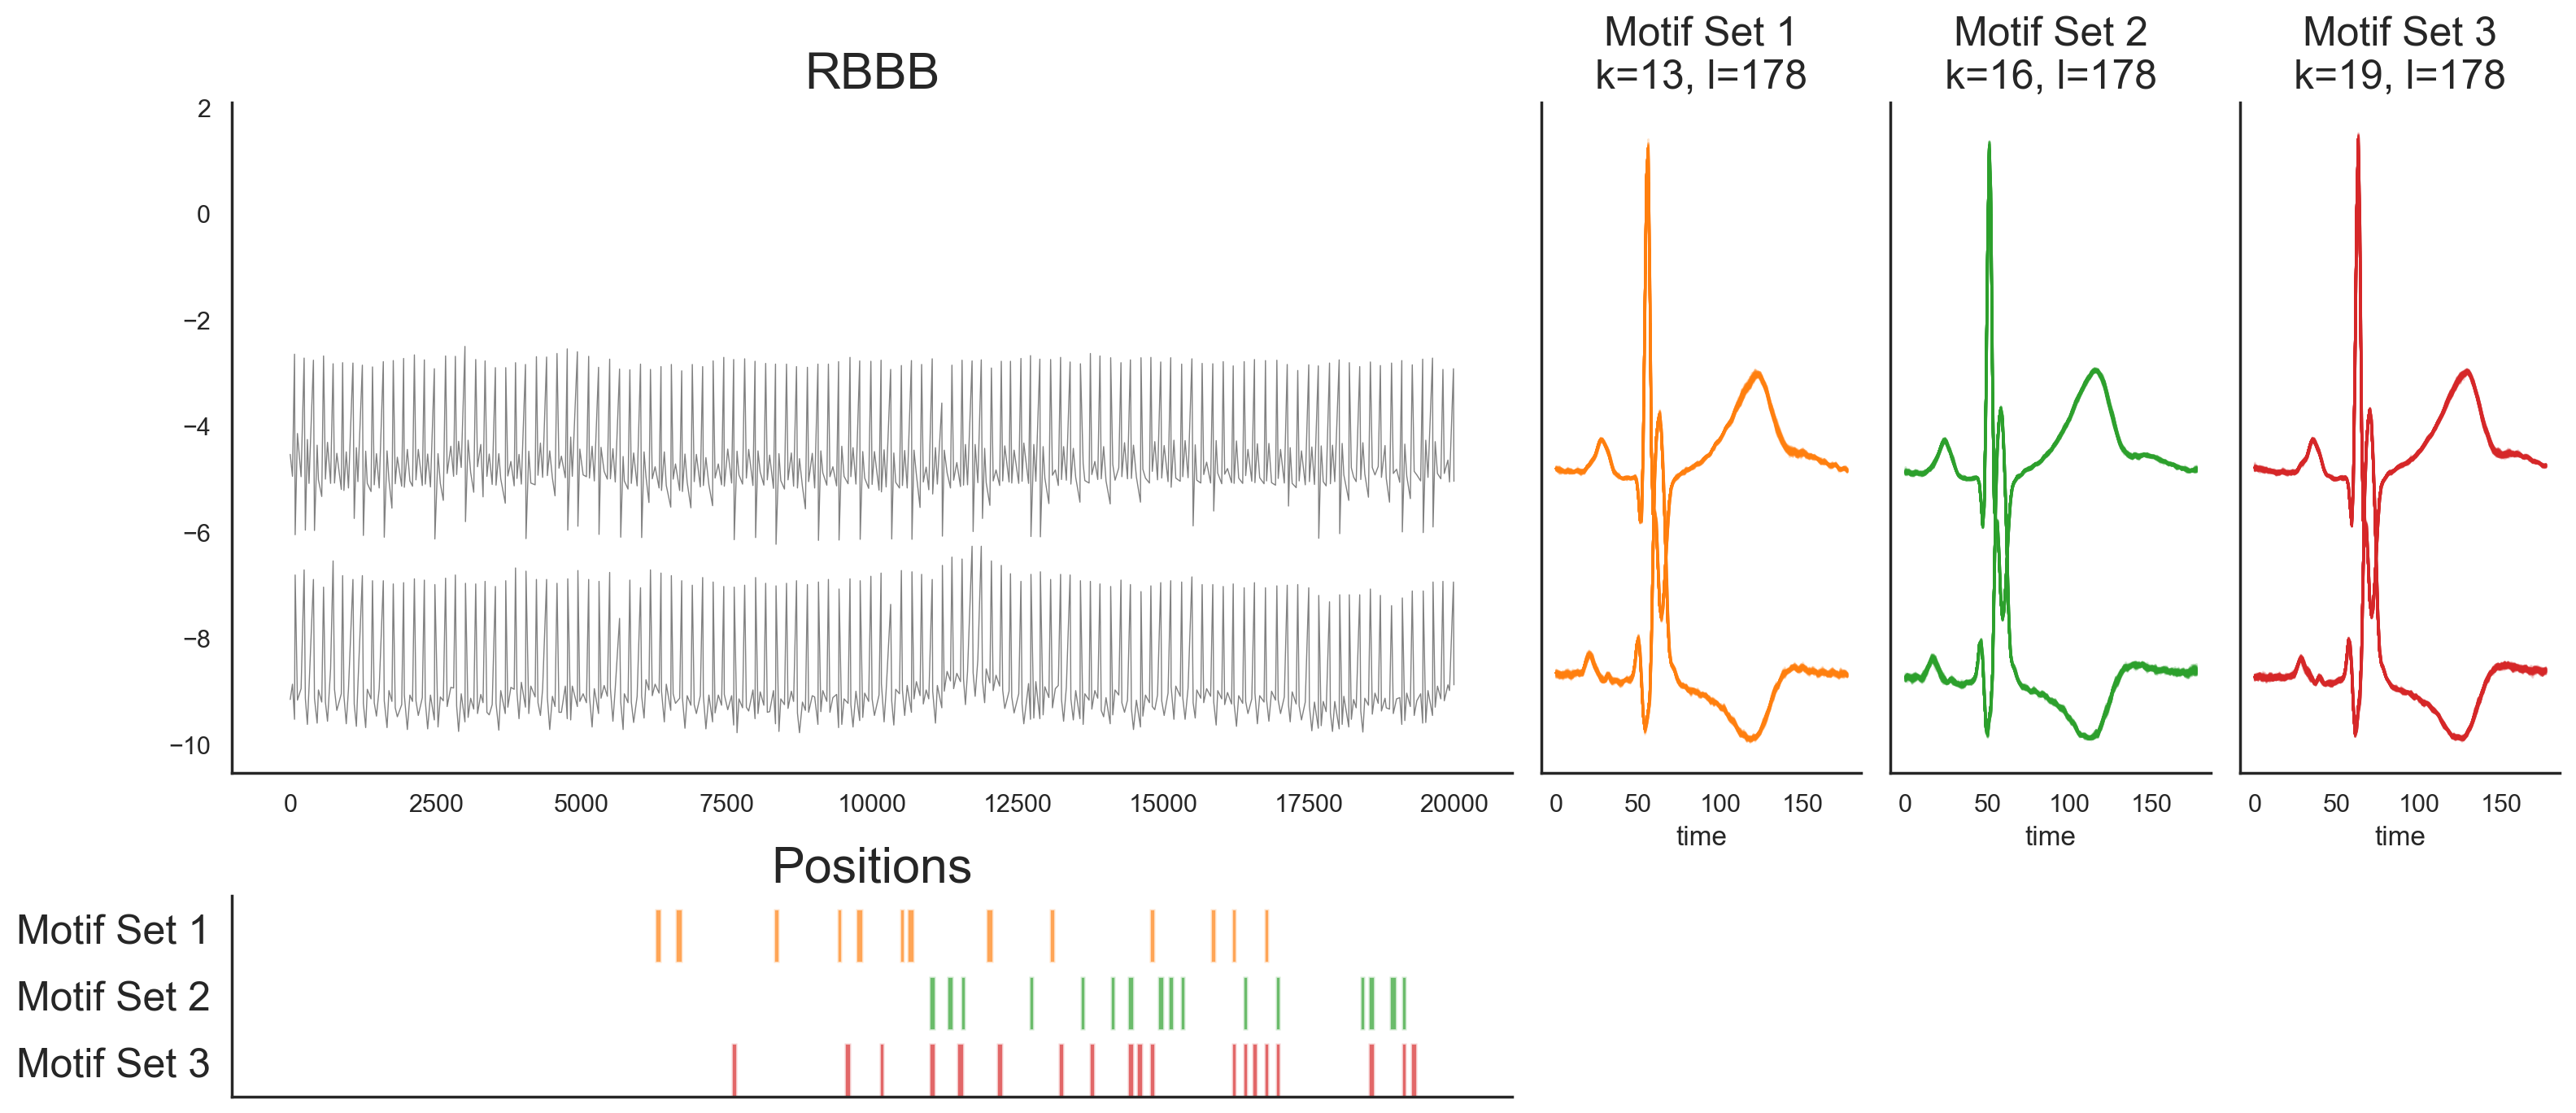

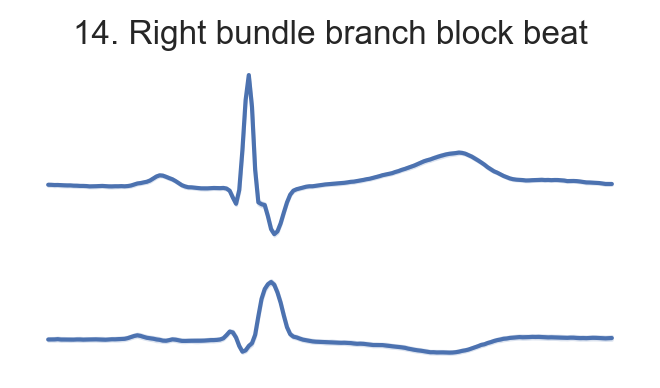

Total time: 156.42083287239075 ms.


In [7]:
k_max = 20
max_segment_size = 20000
tic = time.time()

all_motifs = []
for i, (a, b) in enumerate(zip(cps_class[:-1], cps_class[1:])):
    print (f"Start {a} End {b}")
    b = min(a + max_segment_size, b)
    data = series.iloc[:, a:b].values

    label = ",".join(np.sort(annotations.loc[a:b]["short_description"].unique())) #.iloc[0]
    # print(label)

    # initialize LAMA
    ml = LAMA(
        label,  
        data,
        # ground_truth=df_gt,
        # dimension_labels=df.index,
        n_dims=2,    # number of sub-dimensions
        n_jobs=4     # number of parallel jobs
    )
    
    #_ = ml.plot_dataset()
    # break
    
    window_size = 2*find_dominant_window_sizes(data[0], offset=0.05)
    # print(f"Using Window Size {window_size}")
    
    dists, motif_sets, elbow_points = ml.fit_k_elbow(
        k_max=k_max,
        motif_length=window_size,
        plot_elbows=False,
        plot_motifsets=True,
    )

    
    motif_label = find_label(motif_sets, elbow_points, annotations.loc[a:b], a)
    fig, ax = plot_motiflet(
        data,
        motif_sets[elbow_points[-1]], 
        window_size,
        title=str(i+1) + ". " + motif_label,
    )

    all_motifs.append([a, b, window_size, motif_sets[elbow_points[-1]]])
    
    plt.savefig("images/arrhythmia_"+str(i+1)+"_"+motif_label+".pdf")
    plt.show()

    #break

print(f"Total time: {time.time() - tic} ms.")

# Summary

In [10]:
# all_motifs

In [11]:
"""
fix, ax = plt.subplots(figsize=(60, 5))

for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
    label = cps[i]  
    
    if label in mapping:
        c = colors[(mapping[label]+2) % len(colors)]
    else:
        c = "black"
        
    sns.lineplot(x=np.arange(a,b), linewidth=1,
                 y=series.iloc[0, a:b], ax = ax, label=label,
                 color=c)
    
    ax.axvline(x=b, color="black", linestyle="--", linewidth=1)
    
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
ax.legend().set_visible(False)
ax.axis('off')
plt.tight_layout()
# plt.savefig("images/har_series_annotated.pdf")

for a, b, motif_size, motiflet in all_motifs:
    plot_motiflet(series.iloc[:, a:b].values, motiflet, motif_size)
"""    

'\nfix, ax = plt.subplots(figsize=(60, 5))\n\nfor i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):\n    label = cps[i]  \n    \n    if label in mapping:\n        c = colors[(mapping[label]+2) % len(colors)]\n    else:\n        c = "black"\n        \n    sns.lineplot(x=np.arange(a,b), linewidth=1,\n                 y=series.iloc[0, a:b], ax = ax, label=label,\n                 color=c)\n    \n    ax.axvline(x=b, color="black", linestyle="--", linewidth=1)\n    \nplt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))\nplt.tight_layout()\nsns.despine()\nax.legend().set_visible(False)\nax.axis(\'off\')\nplt.tight_layout()\n# plt.savefig("images/har_series_annotated.pdf")\n\nfor a, b, motif_size, motiflet in all_motifs:\n    plot_motiflet(series.iloc[:, a:b].values, motiflet, motif_size)\n'